In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# Notes on the Finite Volume Method

The objective is to predict the evolution over time and in space of the distribution of one or more variables, such as temperature, concentration, density, pressure, and so on. An important motivation for using the Finite Volume Method (FVM) is that it is amenable to problems where quantities such as mass, momentum, energy, and so on must be conserved both locally and globally. This is very common in physically-based engineering problems.

## The Flow Equation

We need a fluid dynamics problem to solve, so first we must understand the equations used to model flow. We'll start with one of the simplest examples, the *general flow equation* in one dimension:

  $$\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x} = 0$$

Let's see how to derive this equation from first principles and build intuition about what it means. A variable $u$ represents the conserved quantity (e.g. mass), and is called the *dependent variable*. It can vary across the one-dimensional spatial domain $x$, and will evolve through time $t$.

The conservation of $u$ is modelled with a so called *continuity equation* (which is to say the flow equation is also a continuity equation), which, considering the 1-D scalar situation, comprises two terms, the rate of change of the conserved quantity, and the flux density. Let's look at each in turn:

1. The first term represents the rate of change of the conserved quantity $u$ with respect to time:

   $$\frac{\partial u}{\partial t}$$

2. The second term is the *flux density*, which is the flux $f$ per space $x$ (*i.e.* net flux per unit volume):

   $$\frac{\partial f}{\partial x}$$
   
   Imagine a small volume ${\Delta x}$, with the flux $f$ (of conserved quantity $u$) going through it. If we measure how much the flux changes across the volume, the change in flux ${\Delta f}$, will tell us whether the amount of $u$ in the volume is stable, increasing, or decreasing. We need to be careful with sign conventions here. If flux is leaving the volume it is considered positive. If flux is entering the volume it is considered negative. Therefore a uniform flux through the volume from one side to the other will have a negative flux in the inflowing side, and a positive flux on the outflowing side, though these will have the same magnitide. To get the *net flux* ${\Delta f}$ we need to *sum* these signed fluxes. For example, if the flux flowing into the region at $x$ is -3 and the flux flowing out of the region at $x + \Delta x$ is $+3$ , then the net flux, ${\Delta f}$, is $0$, and so the flux density $\frac{\Delta f}{\Delta x}$ is also $0$.
   
   <img src="net-flux-zero.svg" width="500" />
   
   If, however, the flux flowing into the region at $x$ is $-3$ and the flow  out of the region at $x + \Delta x$ is +1, then the net flux is $\Delta f = -3 + 1 = -2$ giving a negative net flux, which indicates that the net flux is inwards to the region, so the amount of $u$ in the region between $x$ and $x + \Delta x$ is increasing.
   
   <img src="net-flux-negative.svg" width="500" />
 
   In the event that the flux at $x$ is $+2$ indicating flow out of the region, and the flux at $x + \Delta x$ is $+3$, also out of the region, then the net flux is $+5$, which indicates net flux is outwards from the region, so the amount of $u$ in the region between $x$ and $x + \Delta x$ is decreasing.
   
   <img src="net-flux-positive.svg" width="500" />
 
   As the size of the region shrinks to be infinitesimal we get the partial derivative term for flux density we started with:

     $$\lim{x \to 0} \frac{\Delta f}{\Delta x} = \frac{\partial f}{\partial x}$$.

   <div class="alert alert-block alert-info">
   The flux density is really the same as what in vector calculus is called the <a href="https://en.wikipedia.org/wiki/Divergence">divergence</a> and remembering this helps remember the sign convention; positive divergence (flux density) is moving away from some point.</div>

   <div class="alert alert-block alert-danger">
   Definitions of flux density vary between mathematics and physics, and from what I can tell between different sub-fields of physics. Apparently, Maxwell is to blame.</div>

Now let's combine the terms. The rate of change of conserved quantity $u$ with respect to time $t$ is equal to the negated flux density, since the sign convention for flux density is that positive flux is decreasing amount, and negative flux is increasing amount:

  $$\frac{\partial u}{\partial t} = - \frac{\partial f}{\partial x}$$
  
This equation is more usually written by gathering terms on the right-hand side, to give:

  $$\boxed{\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x} = 0}$$

This is our *continuity equation* and the simplified *general flow equation* we started with. The zero indicates that quantity $u$ is neither created nor destroyed. 

## Discretisation of space

At the heart of the FVM is the solution of equations by discretising the system in both space (cells) and time (timesteps).

We discretise the spatial domain $x$ into cells.

<img src="discretised-spatial-domain-1d.png" width="500" height="500" />

In the simple example shown above the cells have equal size and the $i$th cell runs from $i - ½$ to $i + ½$. More complex meshing is possible, but we'll keep things simple for now.  In the finite volume method quantities within cells are accumulated, and we account for fluxes between connected cells.

We need to convert our continuous partial differential flow equation:

  $$\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x} = 0$$
  
into discrete form in order to solve it with FVM. The first step in this process is to integrate the flow equation over the spatial domain (*i.e.* with respect to $x$) of a single cell from $x_{i - ½}$ to $x_{i + ½}$, giving:

  $$\int_{x_{i - ½}}^{x_{i + ½}} \frac{\partial u}{\partial t}\,\mathrm{d}x + \int_{x_{i - ½}}^{x_{i + ½}} \frac{\partial f}{\partial x}\,\mathrm{d}x = 0$$


<div class="alert alert-block alert-info">
Integration is a linear operator, which means that the integral of a sum is the sum of the integrals.</div>
 



When we integrate the first term, we can take the differential operator $\frac{\partial}{\partial t}$ outside of the integral, leaving just $u$ on the inside:

  $$\frac{\partial}{\partial t} \int_{x_{i - ½}}^{x_{i + ½}} u\,\mathrm{d}x + \int_{x_{i - ½}}^{x_{i + ½}} \frac{\partial f}{\partial x}\,\mathrm{d}x = 0$$
  
<div class="alert alert-block alert-info">We're allowed to do this because, integration is a linear operator, which means we can move the coefficient out of the integrand.
</div>

Now, rather than the integration over the cell of the rate of change of $u$, we have the rate of change of the integration of $u$ over the cell. In moments of clarity I can see that these are equivalent.

Now we must integrate the second term. Now we're integrating a space derivative $\frac{\partial}{\partial x}$ with respect to x, which yields just the variable $f$:

 $$\int \frac{\partial f}{\partial x}\,\mathrm{d}x = f$$
 
So applying the limits gives:

 $$\int_{x_{i - ½}}^{x_{i + ½}} \frac{\partial f}{\partial x}\,\mathrm{d}x = f_{i + ½} - f_{i - ½}$$
 
<div class="alert alert-block alert-info">This is the <a href="https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus">fundamental theorem of calculus</a>. Let $G(x)$ be an <a href="https://en.wikipedia.org/wiki/Antiderivative">antiderivative</a> of $g(x)$, then
    
    $$\int_a^b g(x)\,\mathrm{d}x = G(b) - G(a)$$
    
This theorem is incredibly useful because it simplifies the integral and means that the definite integral is completely determined by just the values on its boundaries.
</div>

Plugging this back in as the second term of the integrated flow equation, we get:

  $$\frac{\partial}{\partial t} \int_{x_{i - ½}}^{x_{i + ½}} u\,\mathrm{d}x + (f_{i + ½} - f_{i - ½}) = 0$$

In the next step, we'll perform another transformation to the first term, and this is where we transition from the continuous to the discrete. Consider only the definite integral,

  $$\int_{x_{i - ½}}^{x_{i + ½}} u\,\mathrm{d}x$$
 
This is equivalent to integrating the the average value of $u$ across the cell of width $\Delta x$,

<img src="integral-as-average.svg" width="500" />

so we can write,

  $$\int_{x_{i - ½}}^{x_{i + ½}} u\,\mathrm{d}x = {\Delta x} {\bar u_i}$$
 
where $\bar u_i$ is the average value of $u$ in cell $i$.

Substituting this expression back into the first term of the flow equation, gives,

  $$\frac{\partial}{\partial t} {\Delta x} {\bar u}$$

which we can rearrange a bit, moving the ${\Delta x}$ outside the differential operator, we get,

  $${\Delta x} \frac{\partial}{\partial t} {\bar u}$$
  
for the first term of the flow equation. 
  
<div class="alert alert-block alert-info">
Differentiation is also a linear operator, so
    
    $$\frac{\partial}{\partial t} ab = a \frac{\partial}{\partial t} b$$
</div>

Plugging this back into the whole flow equation we get,
 
  $${\Delta x} \frac{\partial}{\partial t} {\bar u} + (f_{i + ½} - f_{i - ½}) = 0$$

Now we take the second term over to the other side:

  $${\Delta x} \frac{\partial}{\partial t} {\bar u} = -(f_{i + ½} - f_{i - ½})$$

An then move the ${\Delta x}$ coefficient over too:

  $$\frac{\partial}{\partial t} {\bar u} = - \frac{1}{\Delta x} (f_{i + ½} - f_{i - ½})$$
  
This reads as: The rate of change of the average value of $u$ in the cell is equal to the negation of the flux density (remember positive flux density is divergence; $u$ leaving the cell).

## Discretisation of time

Having integrated our partial differential equation with respect to space, we now need to integrate it with respect to time. We we used the $i$ *sub*script to identify discrete elements of space, we shall use the $n$ *super*script to identify discrete elements of time.

Considering the left-hand-side of the flow equation, the simplest way to write the rate of change of ${\bar u}$ with respect to time in discrete form is as:

  $$\frac{\partial}{\partial t} {\bar u} = \lim{t \to 0}\:\frac{{\bar u}_i^{n+1} - {\bar u}_i^{n}}{\Delta t}$$
  
<div class="alert alert-block alert-info">
    This is essentially the <a href="https://en.wikipedia.org/wiki/Euler_method">Euler Method</a> – the simplest numerical method for solving ordinary differential equations, where we have a formula for computing the gradient of an unknown curve at a position. We can use the gradient to define a tangent line to predict the next point. The Euler method is the simplest of the <a href="https://en.wikipedia.org/wiki/Runge–Kutta_methods">Runge-Kutta</a> methods.
</div>

Plugging this back into the full flow equation gives,

  $$\frac{{\bar u}_i^{n+1} - {\bar u}_i^{n}}{\Delta t} = - \frac{1}{\Delta x} (f_{i + ½} - f_{i - ½})$$
  
As we cross over from a continuous formulation to a discrete formulation, there is some sleight of hand here, which is the implication that $f$ is now the *average flux over the duration of the timestep* ${\Delta t}$. The notation stays the same, but the meaning has shifted from continuous to discrete.

Moving ${\Delta t}$ over to the right-hand side yields, 

  $${{\bar u}_i^{n+1} - {\bar u}_i^{n}} = - \frac{{\Delta t}}{\Delta x} (f_{i + ½} - f_{i - ½})$$

Which can be rearranged to give the average value of $u$ in the cell at the next time step in terms of its average value at the current time step, the timestep duration, the cell size, and the average cell boundary fluxes:

  $$\boxed{{{\bar u}_i^{n+1} = {\bar u}_i^{n}} - \frac{{\Delta t}}{\Delta x} (f_{i + ½} - f_{i - ½})}$$

## Reconstruction from Average Values

This brief overview omits the details of reconstruction, but covers some important principles.

Using the average values in each cell ${\bar u}_i$ we could attempt to reconstruct the distribution of $u$ within each cell:

<img src="reconstruction-from-average-values.svg" width="500" />

It is important that the space integral of the reconstructed function across the cell is equal to the cell average, in order to honour conservation of $u$.

Using the reconstructed distributions of $u$ within each cell, we can predict the values at the cell boundaries. Note that the predictions for adjacent cells
need not – and in general won't – agree at their mututal interface. In 1-D we
can refer to these as the left-value and the right-value.

<img src="left-right-values.svg" width="500" />

For a given cell interface, using the left-value and the right value we need to calculate the flux across the interface between the two cells. There are various techniques for determining the flux, and the choice affects the numerical stability of the solution.

We will be using the *upwind flux* technique, where, once we have determined the direction of flow between two cells, we base the flux on the upwind (*i.e.* upstream) value of the reconstructed function at the interface.

<img src="upwind-flux.svg" width="500" />

The upwind flux technique is known to be numerically stable.

Once the fluxes $f_{i - ½}$ and $f_{i + ½}$ have been determined, they can be substituted into to discrete flow equation to compute the average conserved value $u$ for the next time step:

 $${{\bar u}_i^{n+1} = {\bar u}_i^{n}} - \frac{{\Delta t}}{\Delta x} (f_{i + ½} - f_{i - ½})$$
 
## Boundary Conditions

In order to apply boundary conditions, we must extend the spatial domain covered by the mesh of cells with so-called *ghost cells*.

<img src="ghost-cells.svg" width="500" />

The number of internal cells will be $N_i$. The number of ghost cells on one boundary will ne $N_g$. Assuming zero-based cell indexing, to iterate over all cells use indices $i$ for $0 \leq i < N_i + 2 N_g$.  To iterate over only the ghost cells use indices $i$ for $N_g \leq i < N_i +  N_g$.

# Scalar Advection Equation in One Dimension

Advection is the passive movement of some scalar field carried along by a flow, such as ink dumped into a river. The spread of ink by diffusion is not part of the advection process.
The advection equation is a [hyperbolic partial differential equation](https://en.wikipedia.org/wiki/Hyperbolic_partial_differential_equation) 

  $$\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0$$

where $u$ is the quantity being advected, $t$ is time, $x$ is space, and $a$ is the **constant** *advection velocity* of the flow.

The advection equation is quite similar to the general flow equation we stated above, and in fact we can express the advection equation for constant velocity flow as the general flow equation. Since $a$ is constant we can move it inside the differential operator of the second term.

  $$\frac{\partial u}{\partial t} + \frac{\partial (a u)}{\partial x} = 0$$
  
This allows us to identify $a u$ as the flux $f$ in the general flow equation we have already seen, and which we know how to discretise:

  $$f = a u$$

  $$\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x} = 0$$
  
That $a u$ is the flux makes sense since the flux is indeed the amount of conserved substance $u$ multiplied by the rate at which is moves (*i.e.* velocity) $a$.

The nature of constant velocity advection is that whatever the initial distribition of $u$ it should be translated to the right (positive $x$ direction) if $a$ is positive. This makes it easy to check visually and numerically whether our solution is correct.





## Implementation

### Simulation Configuration

For the implementation we need the following configuration of the model geometry and simulation duration. It will be convenient to store this configuration in an object, so we can manage multiple simulations concurrently, to facilitate comparisons.

In [2]:
class Config(object):
    pass

config = Config()

The number of internal cells in the $x$-direction:

In [3]:
config.NUM_X_CELLS = 100

The number of ghost cells on either side of the domain. The number of ghost cells required depends on the reconstruction method used. Higher-order reconstructions require more ghost cells:

In [4]:
config.NUM_GHOST_CELLS = 3

The numer of <a href="https://en.wikipedia.org/wiki/Runge–Kutta_methods">Runge-Kutta</a> steps for integration with respect to time (must be at least 1):

In [5]:
config.NUM_RK_STEPS = 1

The $x$ position of the left side of the domain:

In [6]:
config.X_MIN = -1.0

The $x$ position of the right side of the domain:

In [7]:
config.X_MAX = 1.0

Two simulation stopping criteria are also required, a stopping time in seconds:

In [8]:
config.T_MAX = 0.75  # Why not T_MAX for symmetry with X_MAX?

and a maximum number of timestep iterations, which is useful for debugging:

In [9]:
config.MAX_NUM_TIME_ITER = 100000

Finally, as we're solving the advection equation, we need to define the advection velocity:

In [10]:
config.ADVECTION_VELOCITY = 1.0

### Per-cell Data

For each cell we need to keep track of the following information:

* $\bar u$ : The average value of the conserved quantity within the cell (Actually an array per cell to track Runge-Kutta iterations, but consider the zeroth element as the value for now)

* $\Delta x$ : The width of the cell

* centroid $x$ : The centroid position of the cell

* $u_\text{left}$ : The reconstructed $u$ at the left side of the cell

* $u_\text{right}$ : The reconstructed $u$ at the right side of the cell

Apparently, many CFD implementations store the derivatives of $u$ at the centroid rather than storing $u_\text{left}$, and $u_\text{right}$, though the latter technique used here is more general and can be used in the case where the derivatives at the centroid cannot be calculated.


In [11]:
import numpy as np

class Cell:
    
    def __init__(self, cx, dx, num_rk_steps):
        # The quantity u at each Runge-Kutta step with one time step between two
        # inclusive time-levels, hence the +1
        self.u = np.zeros(num_rk_steps + 1)
        
        # The reconstructed values on the left and right boundaries of the cell
        # - initialized to zero for now
        self.u_left = 0.0
        self.u_right = 0.0
    
        # The centroid value
        self.cx = cx
        
        # The cell width
        self.dx = dx
        
        # The total flux
        self.total_flux = 0.0
        
    @property
    def x_left(self):
        return self.cx - self.dx/2.0
    
    @property
    def x_right(self):
        return self.cx + self.dx/2.0

### CFD Algorithm Structure

The basic structure of the *Computational Fluid Dynamics* (CFD) algorithm is as follows in pseudocode:

In [12]:
# Create mesh data structure
# Populate mesh with the grid cells
# Initialize the solution variables(s)
# Write the initial solution to file

# t = 0
# last_time_step = False
# for MAX_NUM_TIME_ITER:
#    calculate dt based on COURANT_NUM
#    if time + dt > STOPPING_TIME:
#        dt = STOPPING_TIME - time
#        time = STOPPING_TIME
#        last_time_step = True

#    for NUM_RK_STEPS:
#        apply boundary conditions
#        reconstruct variable distribition within cell
#        calculate flux
#        update cell average

#    copy_cell_average_to_level_zero

#    t += dt
#    if last_time_step:
#        break

# Write final solution to file


This basic structure will remain largely the same for a wide variety of CFD problems, mesh types and dimensionalities.

The mesh data structure will consist of the internal cells and the ghost cells.

In [13]:
def num_cells(config):
    return config.NUM_X_CELLS + 2*config.NUM_GHOST_CELLS

giving,

In [14]:
num_cells(config)

106

It will be convenient to define the range of indices for real (*i.e.* non-ghost) cells:

In [15]:
def real_cell_indices(config):
    return range(config.NUM_GHOST_CELLS, config.NUM_GHOST_CELLS + config.NUM_X_CELLS)

In this example we shall be using a structured uniform grid in one dimension, so `DX` (${\Delta x}$) can be determined by uniformly dividing the space between `X_MIN` and `X_MAX`:

In [16]:
def dx(config):
    return (config.X_MAX - config.X_MIN) / config.NUM_X_CELLS

giving,

In [17]:
dx(config)

0.02

Now we initialise the array of cells, each with a centroid position, `cx` and a width `dx`. Some careful accounting is required for the positions of the ghost cells which are to the left of `X_MIN`. 

In [18]:
def make_regular_mesh(config):
    cells = [
        Cell(
            cx=config.X_MIN + dx(config)*(c + 0.5 - config.NUM_GHOST_CELLS),
            dx=dx(config),
            num_rk_steps=config.NUM_RK_STEPS,
        ) for c in range(num_cells(config))
    ]
    return cells

Now creating the regular mesh:

In [19]:
cells = make_regular_mesh(config)

At the beginning the initial value of $\bar u$ is set in each cell to describe the initial distribution of $u$ over the domain.

In [20]:
def initialize_square_wave(config, cells):
    # Initialize the zeroth Runge-Kutta step (the current timestep)
    for cell in cells:
        cell.u[0] = 1.0 if -0.25 < cell.cx < 0.25 else 0.0

Lets apply that to our cells:

In [21]:
initialize_square_wave(config, cells)

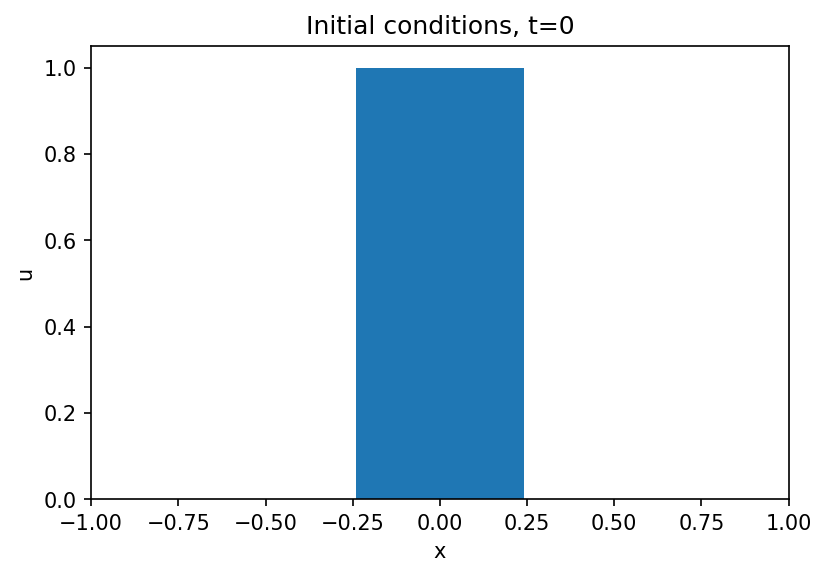

In [22]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

def cell_bar_plot(fig, ax, config, cells, title=None, y_min=None, y_max=None, x_min=None, x_max=None):
    ax.bar(
        [cells[i].x_left for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        width=[cells[i].dx for i in real_cell_indices(config)],
        align="edge"
    )
    ax.set_title(title)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('u')
    ax.set_xlim(
        x_min if (x_min is not None) else config.X_MIN,
        x_max if (x_max is not None) else config.X_MAX,
    )
    ax.set_xlabel('x')
    return fig, ax

fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title="Initial conditions, t=0")
plt.show()

The *Courant Number*, $C$, which is used ensure the time step $\Delta t$ and cell size $\Delta x$ are such that convergence of the numerical solution of the flow equation, which can be ensure the <a href="https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition">convergence condition by Courant–Friedrichs–Lewy</a> is satisfied. Doing do ensures that the simulation has the necessary spatial and temporal resolution.

To calculate $\Delta t$ based on the Courant Number, consider that the advention velocity $a$ is:

  $$a = \frac{\text{distance}}{\text{time}}$$
  
The time step $\Delta t$ size needs to be a function of the grid size $\Delta x$ and the advection velocity $a$ to ensure that advective waves of $u$ are accurately modelled. So we say,

  $$a = \frac{\Delta x}{\Delta t}$$
  
And solve for ${\Delta t}$, ensuring to account for the fact that while $a$ may be positive or negative, ${\Delta t}$ must always be positive; we do this by taking the absolute value, and scaling by the Courant Number, $C$,

  $${\Delta t} = C \frac{\Delta x}{|a|}$$
  
where, $C$ must be less than $C_{\text{max}}$, which is itself dependent on the method chosen to solve the discretised equation.

In [23]:
config.COURANT_NUMBER = 0.2

In [24]:
def time_step_duration(courant_number, dx, a):
    return courant_number * dx / abs(a)

The last time step may be shortened in order to accommodate the specified simulation stopping time.

In [25]:
def simulate(config, cells, simulate_step, boundary_conditions, reconstruct, compute_fluxes, integrate_time_step):
    time = 0.0
    last_time_step = False
    for n in range(config.MAX_NUM_TIME_ITER):
        dt = time_step_duration(config.COURANT_NUMBER, cells[0].dx, config.ADVECTION_VELOCITY)
        if time + dt >= config.T_MAX:
            dt = config.T_MAX - time;
            last_time_step = True
        
        simulate_step(
            config,
            cells,
            time,
            dt,
            boundary_conditions,
            reconstruct,
            compute_fluxes,
            integrate_time_step,
        )
        
        time += dt
        if last_time_step:
            break
            

In [26]:
def simulate_step(config, cells, time, dt, boundary_conditions, reconstruct, compute_fluxes, integrate_time_step):
    for rk in range(config.NUM_RK_STEPS):
        boundary_conditions(config, cells, rk)
        reconstruct(config, cells, rk)
        compute_fluxes(config, cells)
        integrate_time_step(config, cells, rk, dt)
    copy_averages(config, cells)
        

For each Runge-Kutta step, we first apply the boundary conditions. We will be applying periodic boundary conditions, which is to say, we're connecting the left edge of the model to the right edge of the model, effectively wrapping it around an cylinder.

In [27]:
def periodic_boundary_conditions(config, cells, rk):
    """Apply periodic boundary conditions.

    Copy cell values from one real cells on one edge
    of the model to ghost cells on the other.
    """
    for g in range(config.NUM_GHOST_CELLS):
        cells[g].u[rk] = cells[config.NUM_X_CELLS + g].u[rk]
        cells[config.NUM_GHOST_CELLS + config.NUM_X_CELLS + g].u[rk] = cells[config.NUM_GHOST_CELLS + g].u[rk]

Then we reconstruct the distribition of the variable $u$ *within* each cell. For
a first-order reconstruction this will be a constant value equal to the average $\bar u$.

In [28]:
def reconstruct_first_order(config, cells, rk):
    """First-order reconstruction of values at cell boundaries.
    
    This makes the value constant throughout the cell, so the value
    at the boundaries is equal to the average cell value.
    """
    for cell in cells:
        cell.u_left = cell.u[rk]
        cell.u_right = cell.u[rk]

These reconstructed values are used, with an [upwind scheme](https://en.wikipedia.org/wiki/Upwind_scheme) to calculate the flux between adjacent cells.  There are many different upwind schemes; a description of trade-offs in these notes on [accuracy and stability](https://ocw.mit.edu/courses/mathematics/18-086-mathematical-methods-for-engineers-ii-spring-2006/readings/am52.pdf) under the section *Finite Difference Methods*. In this example we use a first-order forward-in-time, centered in space method called the [Lax-Friedrichs method](https://en.wikipedia.org/wiki/Lax–Friedrichs_method).

TODO: I'm not sure it's correct to say this is the Lax-Freidrich's method, or maybe it's just the spatial part of the Lax-Friedrich method.

The computed flux is accumulated for each cell in `total_flux`. Simpler schemes are possible for one-dimension, but this
approach apparently generalises nicely to two dimensions.

In [29]:
def lax_friedrichs_flux(config, cells):
    for cell in cells:
        cell.total_flux = 0.0
    
    # Iterate over the cell interfaces for the real cells. The index i_right
    # refers to cell to the right of interface
    for i_right in range(config.NUM_GHOST_CELLS, config.NUM_GHOST_CELLS + config.NUM_X_CELLS + 1):
        i_left = i_right - 1
        left_value = cells[i_left].u_right
        right_value = cells[i_right].u_left
        
        # Lax-Friedrichs scheme? - TODO: Confirm. Not convinced.
        # when ADVECTION VELOCITY > 0, flux = ADVECTION_VELOCITY * left_value
        # when ADVECTION VELOCITY < 0, flux = ADVECTION_VELOCITY * right_value
        # when ADVECTION VELOCITY = 0, flux = 0
        flux = (
            0.5 * config.ADVECTION_VELOCITY * (left_value + right_value)
            -
            0.5 * abs(config.ADVECTION_VELOCITY) * (right_value - left_value)
        )
        
        cells[i_left].total_flux -= flux
        cells[i_right].total_flux += flux
        

Now we must perform integration over a time step. In fact we do this over a fraction of the time step according to how many Runge-Kutta steps we have configured. We will start by using a first-order Runge-Kutta method (NUM_RK_STEPS = 1), which is equivalent to the [Euler Method](https://en.wikipedia.org/wiki/Euler_method). The Euler method (specifically the *forward* Euler method) projects the solution linearly from a known starting point with the gradient at that point.

<img src="euler-method.svg" width="500" />

The steps taken in the Euler method may either be full time steps (as shown in the diagram) or smaller steps within that (so called Runge-Kutta steps in the code).

In [30]:
def integrate_euler_time_step(config, cells, rk, dt):
    rk_dt = dt / config.NUM_RK_STEPS
    for i in real_cell_indices(config):
        # Euler time step integration
        cells[i].u[rk + 1] = cells[i].u[rk] + cells[i].total_flux * rk_dt / cells[i].dx

The Runge-Kutta steps are smaller steps within the timesteps, and for each cell we maintain an array of $\bar u$ values of size `NUM_RK_STEPS + 1` to allow for storage at the previous time level, each Runge-Kutta step, and the next time level. (Terminology: One *time step* takes us from one *time level* to the next time level).

After the Runge-Kutta iterations, we copy the values updated values from the last element of the array of $\bar u$ values back into the first element, ready for the next time step.

In [31]:
def copy_averages(config, cells):
    for i in real_cell_indices(config):
        cells[i].u[0] = cells[i].u[config.NUM_RK_STEPS]

Now we can run the whole simulation:

In [32]:
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_euler_time_step,
)

And display the results:

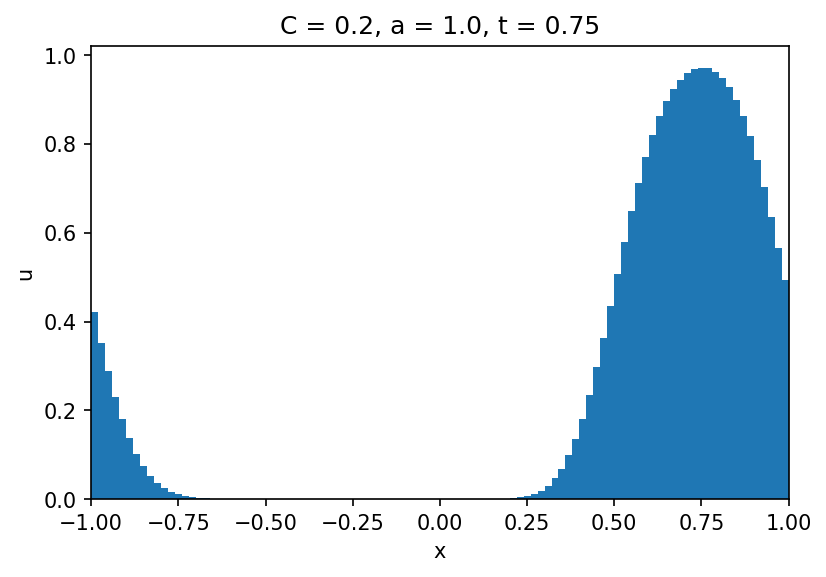

In [33]:
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

The result is not exactly square but is smeared out a little substantially, and causing the height of the peak to be reduced. This is *not* a diffusion effect – we are only modelling advection – but is in fact an artifact of the low-order numerical methods (*i.e.* approximations) we have used to solve the flow equation.

## Error analysis

The quality of the result depends on the Courant Number $C$, which controls the size of the - time step.

By increasing the Courant Number towards 1.0 we can improve the quality of the result, at the expense of requiring more time steps:

In [34]:
config.COURANT_NUMBER = 0.9

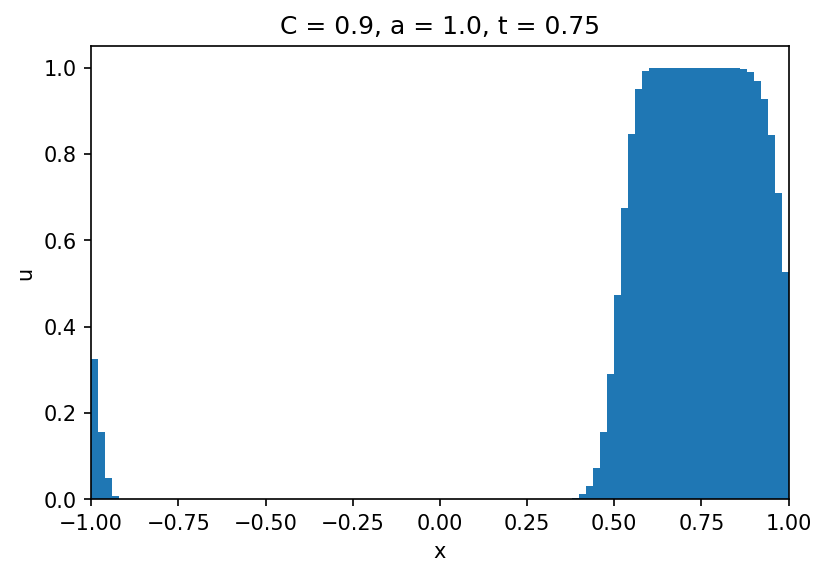

In [35]:
initialize_square_wave(config, cells)
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_euler_time_step,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

At a Courant Number of 1.0 we can achieve an almost perfect result, with a full height wave and sharply defined edges.

In [36]:
config.COURANT_NUMBER = 1.0

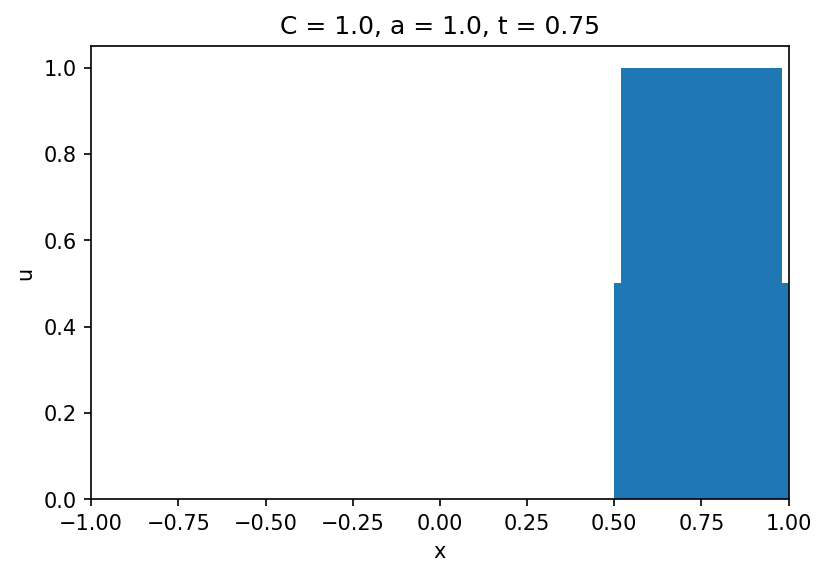

In [37]:
initialize_square_wave(config, cells)
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_euler_time_step,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

However, if we set the Courant Number even a little higher than 1.0, we get highly unstable results, which are completely unusable:

In [38]:
config.COURANT_NUMBER = 1.05

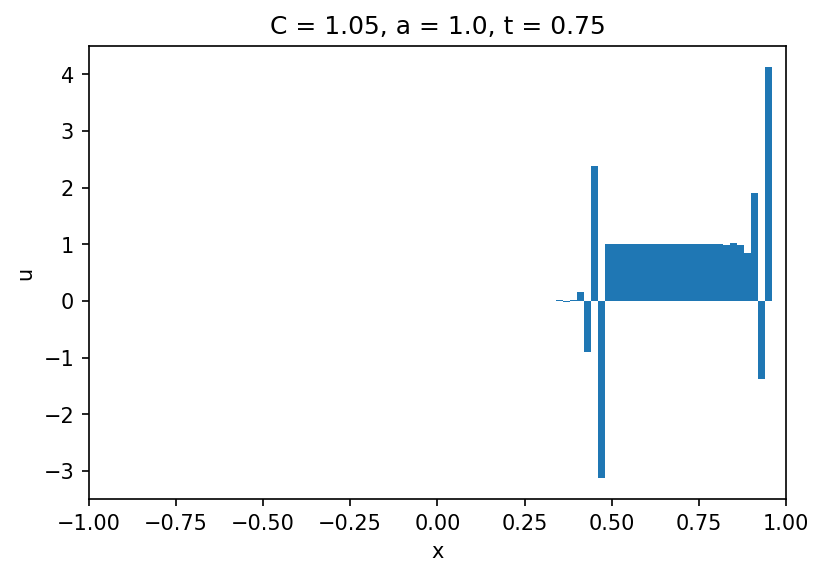

In [39]:
initialize_square_wave(config, cells)
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_euler_time_step,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

Given our periodic domain from $x = -1$ to $x = +1$, with an advection velocity of $a = 1$ a simulation time of 2 seconds should bring the wave back to its starting point, centered around $x = 0$.

In [40]:
config.ADVECTION_VELOCITY = 1.0
config.T_MAX = 2.0
config.COURANT_NUMBER = 1.0

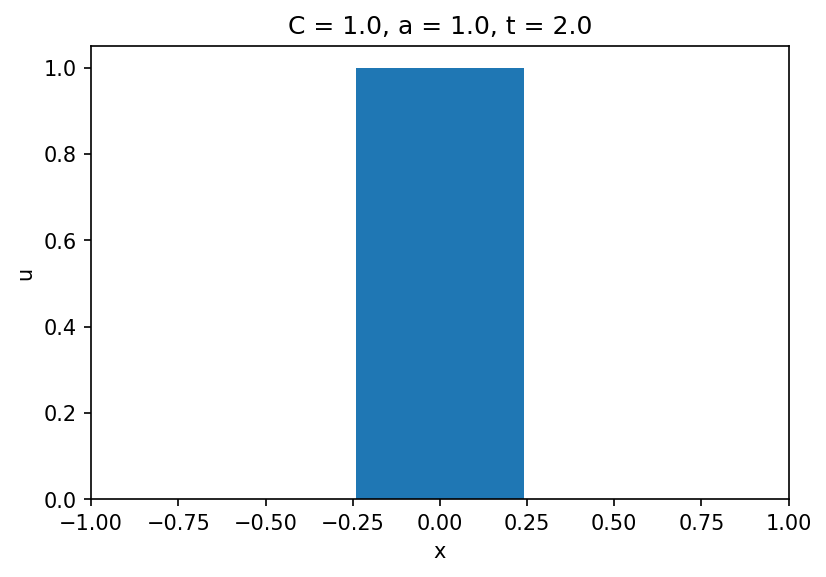

In [41]:
initialize_square_wave(config, cells)
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_euler_time_step,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

We can use this to conveniently show how the varying Courant number affects the quality of the result after the wave has been advected some distance:

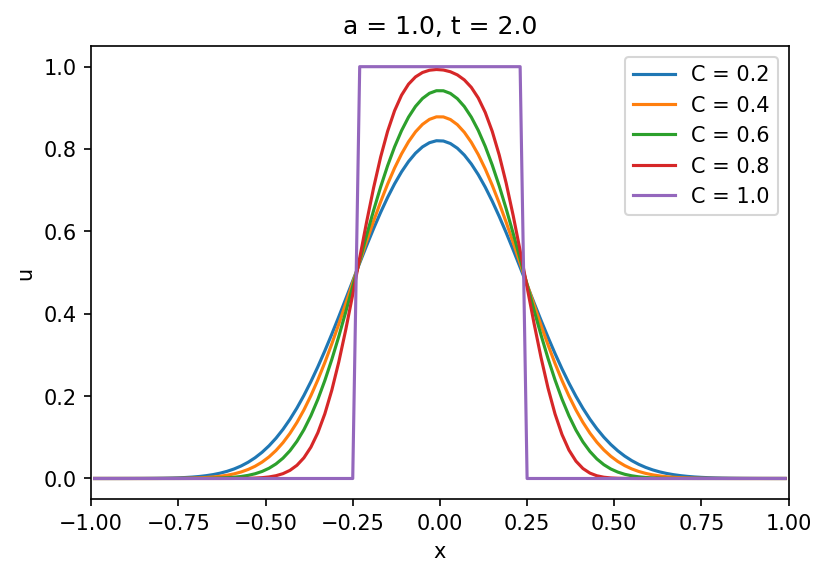

In [42]:
fig, ax = plt.subplots()

ax.set_title(
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

for courant_number in np.arange(0.2, 1.2, 0.2):
    config.COURANT_NUMBER = courant_number
    initialize_square_wave(config, cells)
    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        integrate_euler_time_step,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=f"C = {config.COURANT_NUMBER:.1f}"
    )
ax.legend()
plt.show()

Since the Courant number determines the duration of the time step $\Delta t $ in terms of the cell size $\Delta x$, so it is no surprise that the cells size also affects not only the resolution but also the quality of the result. The following chart shows how the result varies with different numbers of cells:

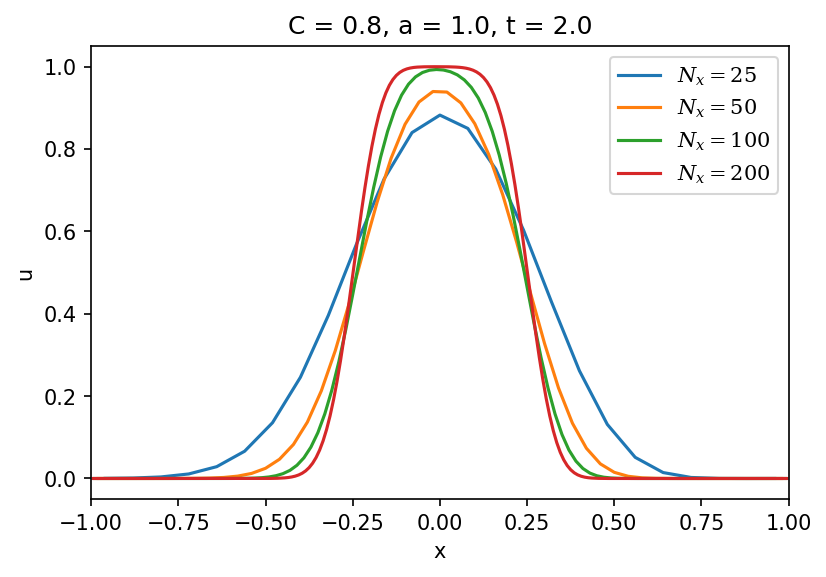

In [43]:
config.COURANT_NUMBER = 0.8

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

for num_x_cells in (25, 50, 100, 200):
    config.NUM_X_CELLS = num_x_cells
    cells = make_regular_mesh(config)

    initialize_square_wave(config, cells)
    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        integrate_euler_time_step,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=f"$N_x = {config.NUM_X_CELLS}$"
    )
ax.legend()
plt.show()

### Error and Order of Accuracy

The error, $E$ can be characterised by the sum of the absolute differences between numerical and exact analytical solutions:

  $$E = \sum_{i = 1}^{N_x} \frac{|u_\text{num} - u_\text{exact}|}{N_x}$$
  
Another way of putting it is that $E$ is the L1-norm of the cell-wise difference vector, divided by the number of cells.

In [44]:
def error(config, cells_a, cells_b):
    return sum(
        abs(cells_a[i].u[0] - cells_b[i].u[0])
        for i in real_cell_indices(config)
    ) / config.NUM_X_CELLS

In numerical analysis the [order of accuracy](https://en.wikipedia.org/wiki/Order_of_accuracy) quantifies the rate of convergence of a numerical solution with respect to a parameter $h$ which characterises the accuracy of the approximation. For example, $h$ could be time step duration $\Delta t$, or cell size ${\Delta x}$ depending on whether we're analysing order of accuracy with respect to time or space. A numerical solution is said to be $n$th-order accurate if the *error* E is proportional to the step size $h$ raised to the $n$th power:

  $$E \propto h^n$$

Considering, order of accuracy with respect to cell size, if we plot the *error* versus the step size ${\Delta x}$ on a log-log plot, the slope of the line will give us the exponent $n$:

  $$n = \frac{\log{E_a} - \log{E_b}}{\log{\Delta x_a} - \log{\Delta x_b}}$$

Alternatively, can plot the *error* versus the number of cells ${N_x}$ on a log-log plot and get a line with the opposite slope sign; in both cases the order of accuracy is given by the magnitude of the slope. So for two meshes $a$ and $b$, with different numbers of cells, and consequently different errors, we get the following expression for order of accuracy with respect to space $n$:

  $$n = -\frac{\log{E_a} - \log{E_b}}{\log{N_{x_a}} - \log{N_{x_b}}}$$

In [45]:
from math import log

def order_of_error(nx_a, error_a, nx_b, error_b):
    return -((log(error_a) - log(error_b))/(log(nx_a) - log(nx_b)))

Comparing the initial conditions with the simulated wave after it has been advected back to the starting point gives us a convenient way of computing the error, $E$. By doing this for simulations with different numbers of cells we can measure the order of accuracy.

In [46]:
config.COURANT_NUMBER = 0.8
errors = {}
for num_x_cells in (10, 25, 50, 100, 200, 1000):
    config.NUM_X_CELLS = num_x_cells
    
    cells_a = make_regular_mesh(config)
    initialize_square_wave(config, cells_a)
    
    cells_b = make_regular_mesh(config)
    initialize_square_wave(config, cells_b)
    
    simulate(
        config,
        cells_b,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        integrate_euler_time_step,
    )
    errors[config.NUM_X_CELLS] = error(config, cells_a, cells_b)
    
from IPython.display import HTML, display
display(
    HTML(
       "<table><tr><th>Nx</th><th>error</th></tr>{}</table>".format(
           "".join(
               "<tr><td>{}</td><td>{:.3f}</td>".format(*item) for item in errors.items()
           )
        )
    )
)

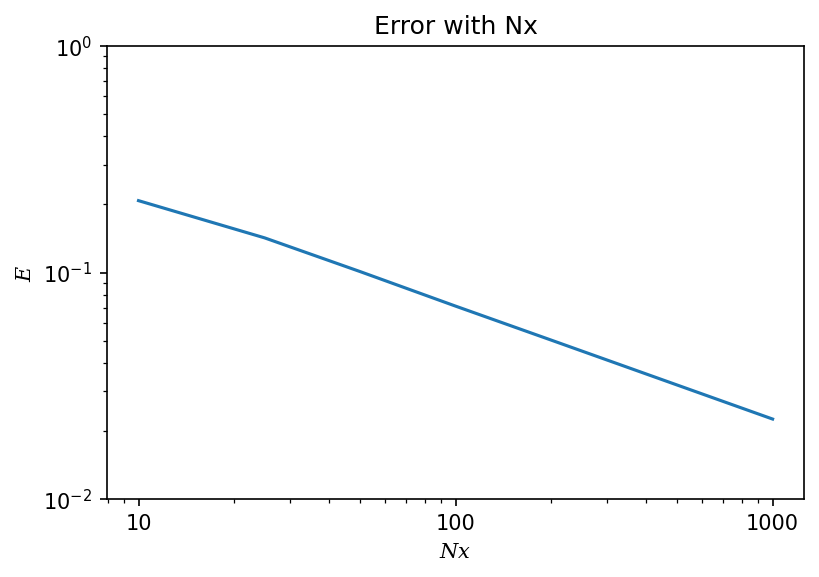

In [47]:
from math import floor, ceil, log10
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots()

def nx_error_plot(fig, ax, errors, label=None):
    ax.plot(
        errors.keys(),
        errors.values(),
        label=label
    )
    ax.set_title("Error with Nx")
    ax.set_ylabel('$E$')
    ax.set_yscale('log')
    
    error_min = min(errors.values())
    error_max = max(errors.values())
    
    ymin_pow = floor(log10(error_min))
    ymax_pow = ceil(log10(error_max))

    y_ticks = [10**i for i in range(ymin_pow, ymax_pow + 1)]
    
    ax.set_yticks(y_ticks)
    ax.set_xlabel('$Nx$')
    ax.set_xscale('log')
    ax.set_xticks((1e1, 1e2, 1e3))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
nx_error_plot(fig, ax, errors)
plt.show()

The absolute values of the slopes of the segments of this line from left to right, giving the Order of Accuracy $n$, are as follows: 

In [48]:
from more_itertools import pairwise

orders = [order_of_error(nx_a, e_a, nx_b, e_b) for (nx_a, e_a), (nx_b, e_b) in pairwise(errors.items())]

orders

[0.41316908510228995,
 0.4942630004558983,
 0.5063664762511038,
 0.49747536047582813,
 0.49913014489139607]

The values appear to be converging on $n = ½$. This is surprising, because we have used first-order schemes for spatial reconstruction, flux calculation, and time integration, so we should expect an order of accuracy of approximate $n = 1$. But we need to be careful: Being a square wave, the initial conditions contain a discontinuity which can cause the order of accuracy to be lower for this specific case than it could be. To determine the maximum order of accuracy for the method, we should use a smoothly varying initial condition, such as a sine wave.


In [49]:
from math import pi, sin

def initialize_sine_wave(config, cells):
    # Initialize the zeroth Runge-Kutta step (the current timestep)
    for cell in cells:
        cell.u[0] = (1+sin(2*pi*cell.cx/(config.X_MAX - config.X_MIN)))/2  

We can use this to initialize a new model:

In [50]:
config.NUM_X_CELLS = 200
initialize_sine_wave(config, cells)

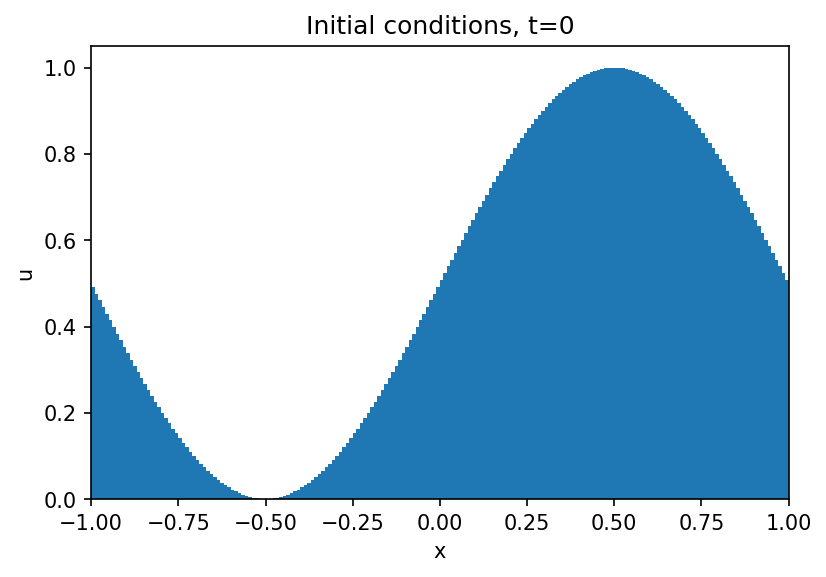

In [51]:
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title="Initial conditions, t=0")
plt.show()

Running the order of error analysis again with these smooth initial conditions:

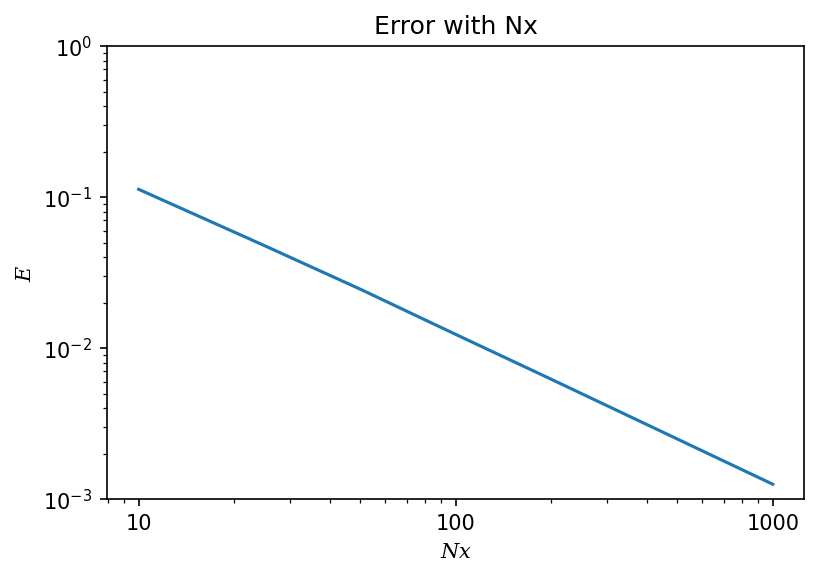

In [52]:
config.COURANT_NUMBER = 0.8
errors = {}
for num_x_cells in (10, 25, 50, 100, 200, 1000):
    config.NUM_X_CELLS = num_x_cells
    
    cells_a = make_regular_mesh(config)
    initialize_sine_wave(config, cells_a)
    
    cells_b = make_regular_mesh(config)
    initialize_sine_wave(config, cells_b)
    
    simulate(
        config,
        cells_b,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        integrate_euler_time_step,
    )
    errors[config.NUM_X_CELLS] = error(config, cells_a, cells_b)
    
fig, ax = plt.subplots()
nx_error_plot(fig, ax, errors)
plt.show()

With converging error orders as follows:

In [53]:
orders = [order_of_error(nx_a, e_a, nx_b, e_b) for (nx_a, e_a), (nx_b, e_b) in pairwise(errors.items())]

orders

[0.9396258403072056,
 0.9547888606235296,
 0.994510944191475,
 0.9859993267308305,
 0.9951266434714144]

As $N_x$ increases with this smooth solution, the order of error appears to be converging on $n = 1$, which is what we would expect for the first-order numerical methods we have used.

Given that the order of accuracy we determine numerically depends on the nature of the solution, instead of,

  $$E \propto h^n$$
    
we can say,

  $$E \leq Ch^n$$

where $C$ is some constant related to the nature of the solution $u$. (Note: This $C$ is unrelated to the Courant Number).

## Second-order solution

As we have seen, our existing solution is first-order. We can improve it by implementing second-order integration in both time and space. We will use a second-order Runge-Kutta scheme:

  $$u^{(1)} = u^n + \Delta t \mathcal{L}(u^n)$$
  
  $$u^{n+1} = \frac{1}{2}u^n + \frac{1}{2}u^{(1)} + \frac{1}{2}\Delta t \mathcal{L}(u^{(1)})$$
  
where,

  $$\mathcal{L}(u) =  \frac{\partial u}{\partial t}$$
  
in otherwords, the gradient of $u$ with respect to time.  This second-order Runge-Kutta algorithm is called the midpoint algorithm. It works by using an estimate of the gradient at $t_n$ to generate an estimate of $u$ half way through time time step, $u_{n+½}$. This is then used to estimate gradient at the midpoint, which we then extrapolate to cover the second half of time step to estimate $u_{n+1}$.

In [54]:
def integrate_runge_kutta_second_order_time_step(config, cells, rk, dt):
    if not config.NUM_RK_STEPS == 2:
        raise RuntimeError("Second-order Runge Kutta requires 2 RK steps")
    for i in real_cell_indices(config):
        # Note that the total_flux is recalculated between RK steps so the gradient changes
        # between iterations even though the expression in the code is the same
        if rk == 0:
            # Euler time step integration
            cells[i].u[rk + 1] = (
                cells[i].u[rk]
                + cells[i].total_flux * dt / cells[i].dx
            )
        elif rk == 1:
            cells[i].u[rk + 1] = (
                0.5 * (
                    cells[i].u[rk - 1]  # un
                    + cells[i].u[rk]    # u1
                    + cells[i].total_flux * dt / cells[i].dx
                )
            )
        else:
            raise RuntimeError(f"Unexpected rk {rk} for second-order Runge Kutta")

Configuring for two-step Runge-Kutta,

In [55]:
config.COURANT_NUMBER = 0.6
config.NUM_X_CELLS = 100
config.NUM_RK_STEPS = 2

and plugging in our second-order time integration algorithm,

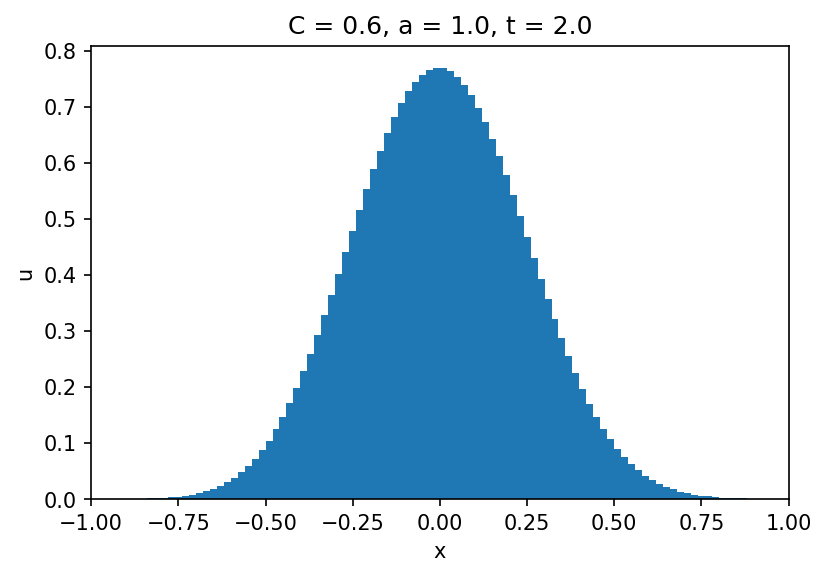

In [56]:
cells = make_regular_mesh(config)
initialize_square_wave(config, cells)
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_first_order,
    lax_friedrichs_flux,
    integrate_runge_kutta_second_order_time_step,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()


This gives a reasonable result for the wave having been advected back to its started position. Let's compare it to the first-order time integration?

In [57]:
TIME_STEP_INTEGRATORS = {}
TIME_STEP_INTEGRATORS[1] = integrate_euler_time_step
TIME_STEP_INTEGRATORS[2] = integrate_runge_kutta_second_order_time_step

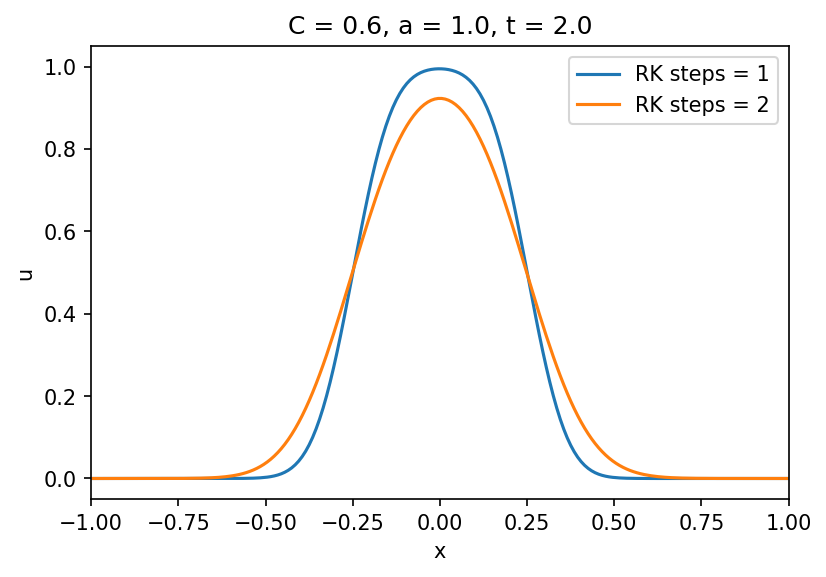

In [58]:
config = Config()
config.NUM_X_CELLS = 200
config.NUM_GHOST_CELLS = 3
config.X_MIN = -1.0
config.X_MAX = 1.0
config.T_MAX = 2.0
config.MAX_NUM_TIME_ITER = 100000
config.COURANT_NUMBER = 0.6
config.ADVECTION_VELOCITY = 1.0

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

for num_rk_steps in (1, 2):
    config.NUM_RK_STEPS = num_rk_steps
    time_step_integrator = TIME_STEP_INTEGRATORS[num_rk_steps]

    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=f"RK steps = {config.NUM_RK_STEPS}"
    )

ax.legend()
plt.show()

Seems to me that the second-order result is worse than the first-order result, but my results are at least consistent with the results from the lecture series I'm following.

Let's press on with a third-order Runge-Kutta time integration scheme, given as:

  $$u^{(1)} = u^n + \Delta t \mathcal{L}(u^n)$$
  
  $$u^{(2)} = \frac{3}{4}u^n + \frac{1}{4}u^{(1)} + \frac{1}{4}\Delta t \mathcal{L}(u^{(1)})$$
    
  $$u^{n+1} = \frac{1}{3}u^n + \frac{2}{3}u^{(2)} + \frac{2}{3}\Delta t \mathcal{L}(u^{(2)})$$
  
This is known as Strong Stability-Preserving Runge-Kutta 3, or SSP-RK3. SSP methods are also known as [total variation diminishing](https://en.wikipedia.org/wiki/Total_variation_diminishing), contractivity preserving, or monotonicity preserving methods. These are from Gottlieb, Shu & Tadmore (2001) [Strong Stability-Preserving High-Order Time Discretization Methods](https://www.math.umd.edu/~tadmor/pub/linear-stability/Gottlieb-Shu-Tadmor.SIREV-01.pdf). SIAM Review 43.  Apparently another approachable reference for these is Durran, Dale R. (2010) [Numerical Methods for Fluid Dynamics: With Applications to Geophysics](https://www.amazon.com/Numerical-Methods-Fluid-Dynamics-Applications/dp/1461426855). See also [Optimal Strong-Stability-Preserving Runge–Kutta Time Discretizations for Discontinuous Galerkin Methods](https://repository.kaust.edu.sa/bitstream/handle/10754/333639/dg_ssp_stability.pdf;sequence=1)

In [59]:
def integrate_runge_kutta_third_order_time_step(config, cells, rk, dt):
    if not config.NUM_RK_STEPS == 3:
        raise RuntimeError("Third-order Runge Kutta requires 3 RK steps")
    for i in real_cell_indices(config):
        # Note that the total_flux is recalculated between RK steps so the gradient changes
        # between iterations even though the expression in the code is the same
        if rk == 0:
            # Euler time step integration
            cells[i].u[rk + 1] = (
                cells[i].u[rk]
                + cells[i].total_flux * dt / cells[i].dx
            )
        elif rk == 1:
            cells[i].u[rk + 1] = (
                3/4 * cells[i].u[rk - 1]  # un
                + 1/4 * cells[i].u[rk]    # u1
                + 1/4 * cells[i].total_flux * dt / cells[i].dx
            )
            
        elif rk == 2:
            cells[i].u[rk + 1] = (
                1/3 * cells[i].u[rk - 2]  # un
                + 2/3 * cells[i].u[rk]    # u1
                + 2/3 * cells[i].total_flux * dt / cells[i].dx
            )
        else:
            raise RuntimeError(f"Unexpected rk {rk} for second-order Runge Kutta")

Let's register our new integrator:

In [60]:
TIME_STEP_INTEGRATORS[3] = integrate_runge_kutta_third_order_time_step

and compare it to the first- and second-order integrators.

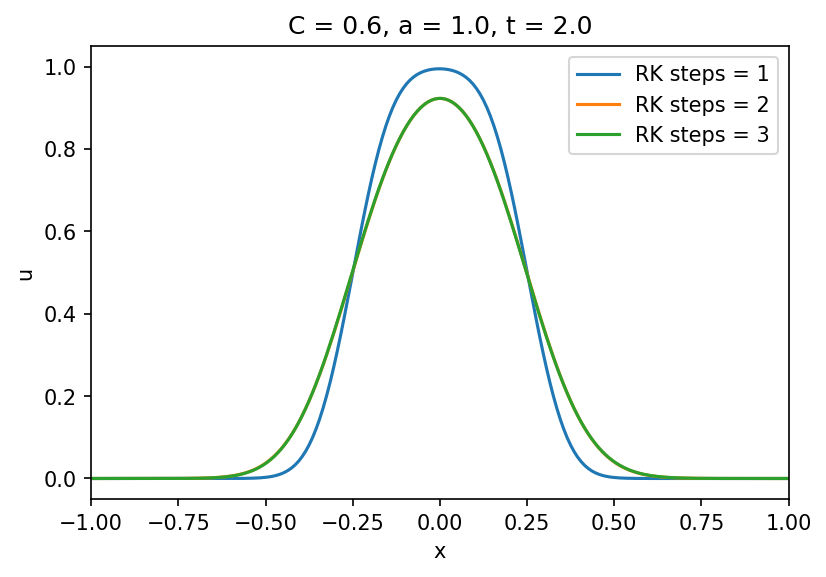

In [61]:
config = Config()
config.NUM_X_CELLS = 200
config.NUM_GHOST_CELLS = 3
config.X_MIN = -1.0
config.X_MAX = 1.0
config.T_MAX = 2.0
config.MAX_NUM_TIME_ITER = 100000
config.COURANT_NUMBER = 0.6
config.ADVECTION_VELOCITY = 1.0

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

for num_rk_steps in (1, 2, 3):
    config.NUM_RK_STEPS = num_rk_steps
    time_step_integrator = TIME_STEP_INTEGRATORS[num_rk_steps]

    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstruct_first_order,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=f"RK steps = {config.NUM_RK_STEPS}"
    )

ax.legend()
plt.show()

This appears to give very similar, possibly identical results, to the RK2 method, but still with more dispersion that the first-order method.

### Higher-order state variable reconstruction

#### Backwards difference reconstruction (Beam and Warming)

We have already implemented first-order variable reconstruction in `reconstruct_first_order`.  Now we will implement reconstruction according to the [Beam and Warming scheme](https://en.wikipedia.org/wiki/Beam_and_Warming_scheme).

In this scheme the gradient at the centroid of cell $i$, is given by the backwards difference,

  $$\left.\frac{\partial u}{\partial x}\right|_i \approx \frac{u_i - u_{i-1}}{\Delta x}$$
  
and this slope is extrapolated backwards to the cell boundary at $i - ½$ and forwards to the cell boundary at $i + ½$ to give left and right values $u_{i - ½}$ and $u_{i + ½}$ respectively.

In [62]:
def reconstruct_beam_warming(config, cells, rk):
    """Beam and Warming reconstruction of values at cell boundaries.
    
    Using backwards differences.
    """
    for i in range(config.NUM_GHOST_CELLS - 1, config.NUM_X_CELLS + config.NUM_GHOST_CELLS + 1):
        # This routine assumes a regular grid with constant dx
        dx = cells[i].dx
        du_dx = (cells[i].u[rk] - cells[i - 1].u[rk]) / dx 
        cells[i].u_left = cells[i].u[rk] - du_dx * dx/2.0
        cells[i].u_right = cells[i].u[rk] + du_dx * dx/2.0

Configuring for SSP-RK3 time integration,

In [63]:
config = Config()
config.NUM_X_CELLS = 200
config.NUM_GHOST_CELLS = 3
config.X_MIN = -1.0
config.X_MAX = 1.0
config.T_MAX = 2.0
config.MAX_NUM_TIME_ITER = 100000
config.COURANT_NUMBER = 0.6
config.ADVECTION_VELOCITY = 1.0
config.NUM_RK_STEPS = 3

We can run the simulation with the Beam and Warming reconstructor,

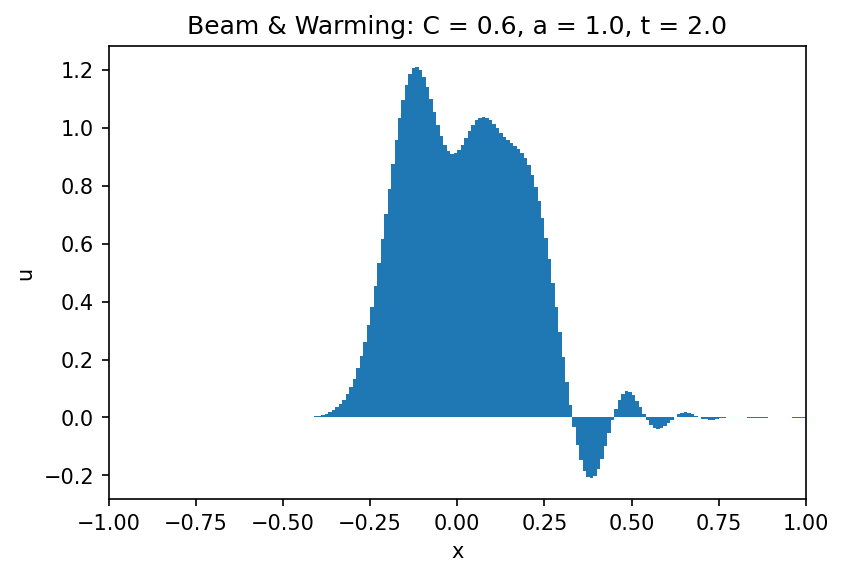

In [64]:
cells = make_regular_mesh(config)
initialize_square_wave(config, cells)
time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_beam_warming,
    lax_friedrichs_flux,
    time_step_integrator,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        "Beam & Warming: "
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

The Beam and Warming scheme has considerable overshoot and oscillation associated with the edges of square wave. These oscillations are on the *leading* side of the discontinuities in the initial conditions.

In order to compare different state variable reconstructors, let's set up a mapping of reconstructor functions,

In [65]:
RECONSTRUCTORS = {}
RECONSTRUCTORS["First-Order"] = reconstruct_first_order
RECONSTRUCTORS["Beam-Warming"] = reconstruct_beam_warming

so we can compare reconstructor performance,

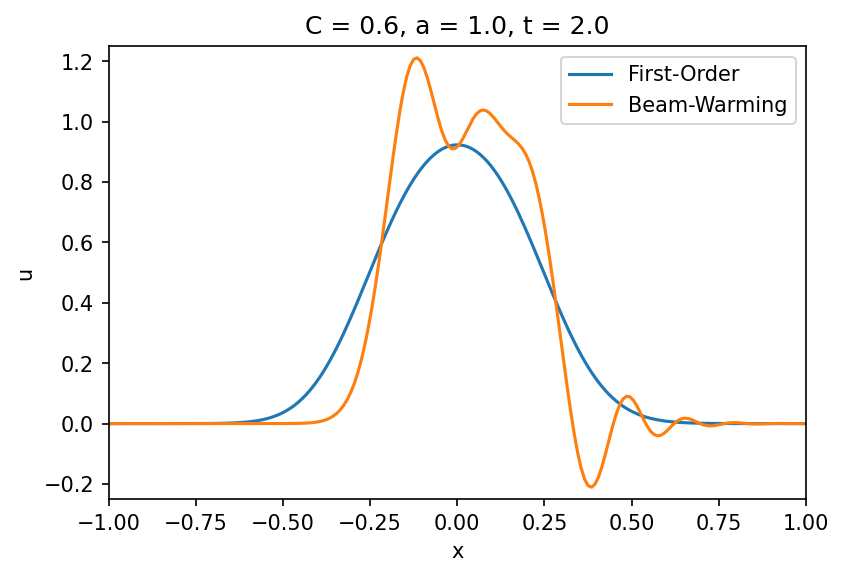

In [66]:
fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend()
plt.show()

In spite of the overshoot and oscillations which are artefacts of the numerical method, the edges of the pulse are considerably steeper and closer to the ideal, with less dispersion than the first-order method.

#### Forward difference reconstruction (Lax-Wendroff)

Rather than using backwards differences as in the Beam-Warming scheme, we can use forward differences in the [Lax-Wendroff](https://en.wikipedia.org/wiki/Lax–Wendroff_method) method.

In this scheme the gradient at the centroid of cell $i$, is given by the forwards difference,

  $$\left.\frac{\partial u}{\partial x}\right|_i \approx \frac{u_{i+1} - u_{i}}{\Delta x}$$
  
and this slope is extrapolated backwards to the cell boundary at $i - ½$ and forwards to the cell boundary at $i + ½$ to give left and right values $u_{i - ½}$ and $u_{i + ½}$ respectively.

In [67]:
def reconstruct_lax_wendroff(config, cells, rk):
    """Lax-Wendroff reconstruction of values at cell boundaries.
    
    Using forwards differences.
    """
    for i in range(config.NUM_GHOST_CELLS - 1, config.NUM_X_CELLS + config.NUM_GHOST_CELLS + 1):
        # This routine assumes a regular grid with constant dx
        dx = cells[i].dx
        du_dx = (cells[i + 1].u[rk] - cells[i].u[rk]) / dx 
        cells[i].u_left = cells[i].u[rk] - du_dx * dx/2.0
        cells[i].u_right = cells[i].u[rk] + du_dx * dx/2.0

Then, after registering our new reconstructor,

In [68]:
RECONSTRUCTORS["Lax-Wendroff"] = reconstruct_lax_wendroff

we can compare its performance with the existing reconstructors:

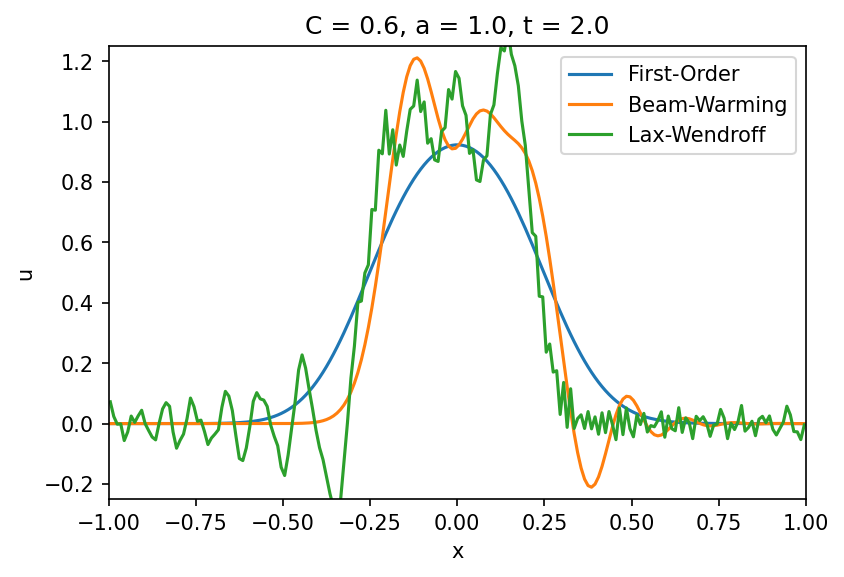

In [69]:
fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend()
plt.show()

Now the oscillations are larger, more pervasive, and are *trailing* the discontinuities in the initial conditions. However, in spite of the osciallations, the method is numerically stable and does not blow up.

<div class="alert alert-block alert-warning">
    The Beam-Warming and Lax-Wendroff methods presented here are not exactly equivalent to the published methods because our estimates of the $\frac{\partial u}{\partial x}$ derivative are based on instantaneous values of $u$ and do not account for the fact thet $u$ is changing over time. The true Beam-Warming and Lax-Wendroff method account for the need to integrate over time when determining the values of $u$ at the cell boundaries. That said, this is mitigated (apparently) to a large degree by the use of multi-step Runge-Kutta time integration methods, so the simplified variable reconstruction methods presented here retain the important properties of Beam-Warming and Lax-Wendroff.
</div>

#### Central difference reconstruction (Fromm)

Where Beam-Warming used backward differences, and Lax-Wendroff uses forward differences, the Fromm method uses *central differences*.

In this scheme the gradient at the centroid of cell $i$, is given by the central difference, which to say the difference between the value in the forwards cell and the value in the backwards cell:

  $$\left.\frac{\partial u}{\partial x}\right|_i \approx \frac{u_{i+1} - u_{i-1}}{2 \Delta x}$$
  
and this slope is extrapolated backwards to the cell boundary at $i - ½$ and forwards to the cell boundary at $i + ½$ to give left and right values $u_{i - ½}$ and $u_{i + ½}$ respectively.

In [70]:
def reconstruct_fromm(config, cells, rk):
    """Fromm reconstruction of values at cell boundaries.
    
    Using central differences.
    """
    for i in range(config.NUM_GHOST_CELLS - 1, config.NUM_X_CELLS + config.NUM_GHOST_CELLS + 1):
        # This routine assumes a regular grid with constant dx
        dx = cells[i].dx
        du_dx = (cells[i + 1].u[rk] - cells[i - 1].u[rk]) / (2*dx) 
        cells[i].u_left = cells[i].u[rk] - du_dx * dx/2.0
        cells[i].u_right = cells[i].u[rk] + du_dx * dx/2.0

Adding this method in our registry of state variable reconstruction funcions,

In [71]:
RECONSTRUCTORS["Fromm"] = reconstruct_fromm

we can check its behaviour versus the others:

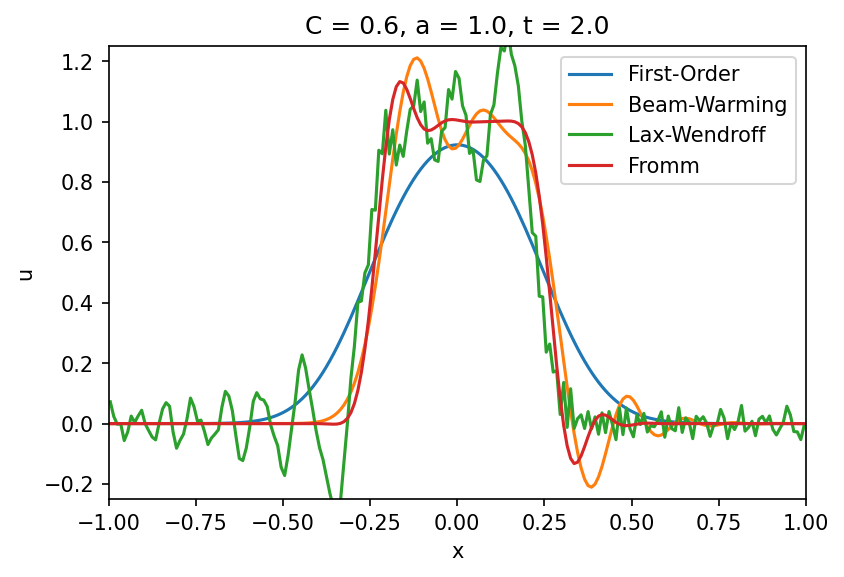

In [72]:
# Ensure that the advection velocity, model width conspire to move the
# wave back to it's initial position at T_MAX, so the initial conditions can be
# used as an exact solution to compare methods
assert (config.T_MAX * config.ADVECTION_VELOCITY) % (config.X_MAX - config.X_MIN) == 0.0, \
       "Advection velocity does not transport an exact number of spatial periods"

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend()
plt.show()

While there are fairly large leading and small trailing oscillations, they are much reduced compared to the other methods.

All three of these methods are stable and thet have different stability limits, but the CFL criteria are be different for each of methods (this is not elaborated further here). I think this means that the range of Courant Numbers for which the method is stable differs for each method.

With the second-order reconstruction methods, the very high gradients near the discontinuities lead to overshoot (the estimates of $u$ at the cell boundaries are too high or too low) which leads to unphysical fluxes. The high unphysicaly fluxes can be managed using *limiters*.

## Why higher-order methods are required

We have seen that the first-order reconstruction method produced a smooth and well-behaved solution, albeit one which did not accurately model discontinuities, which high levels of dispersion.  All of the second-order methods we tried introduced oscillations into the solution around discontinuities, which are unnacceptable in most cases.  Given the lower complexity of the first-order methods, why should we not just use a higher number of cells with first-order state variable reconstruction?

Let's compare the performance of the methods with smoothly varying initial conditions – a sine wave:

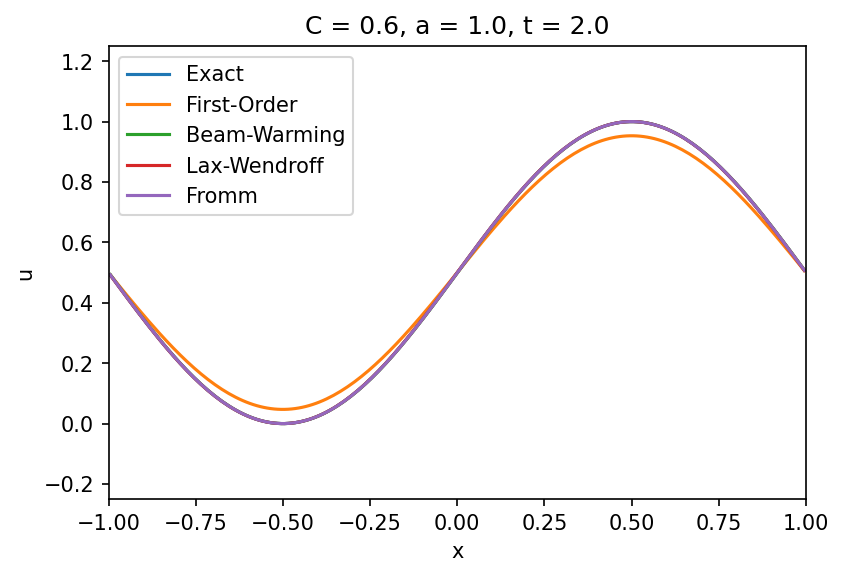

In [73]:
# Ensure that the advection velocity, model width conspire to move the
# wave back to it's initial position at T_MAX, so the initial conditions can be
# used as an exact solution to compare methods
assert (config.T_MAX * config.ADVECTION_VELOCITY) % (config.X_MAX - config.X_MIN) == 0.0, \
       "Advection velocity does not transport an exact number of spatial periods"

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

exact_cells = make_regular_mesh(config)
initialize_sine_wave(config, exact_cells)
ax.plot(
    [exact_cells[i].cx for i in real_cell_indices(config)],
    [exact_cells[i].u[0] for i in real_cell_indices(config)],
    label="Exact"
)

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_sine_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend()
plt.show()

When used with a smoothly varying state variable, we can see that the second-order reconstructors almost exactly reproduce the exact solution, to the extend that they all overplot the exact solution curve. The numerical dispersion of the first-order method causes it to be less accurate than the higher-order methods.

If we extend the model run time from two seconds to 20 seconds,

In [74]:
config.T_MAX = 20.0

the effect is much more pronounced:

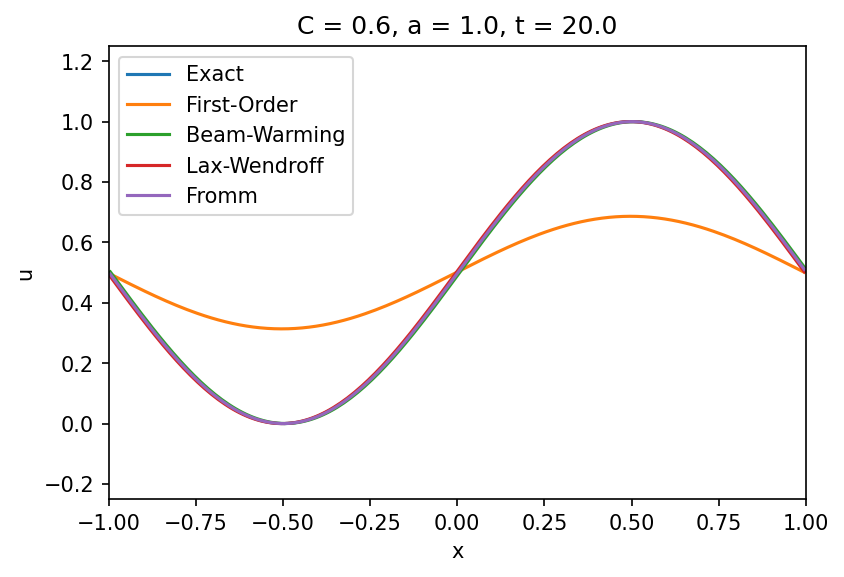

In [75]:
# Ensure that the advection velocity, model width  conspire to move the
# wave back to it's initial position at T_MAX, so the initial conditions can be
# used as an exact solution to compare methods
assert (config.T_MAX * config.ADVECTION_VELOCITY) % (config.X_MAX - config.X_MIN) == 0.0, \
       "Advection velocity does not transport an exact number of spatial periods"

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

exact_cells = make_regular_mesh(config)
initialize_sine_wave(config, exact_cells)
ax.plot(
    [exact_cells[i].cx for i in real_cell_indices(config)],
    [exact_cells[i].u[0] for i in real_cell_indices(config)],
    label="Exact"
)

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_sine_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend()
plt.show()

At a time-level of 20.0 seconds the numerical dispersion of the first-order method has become unacceptable, which all the higher-order methods give excellent accuracy.

By performing the order of accuracy analysis for the different methods, we can can demonstrate that our higher-order methods are indeed second order.

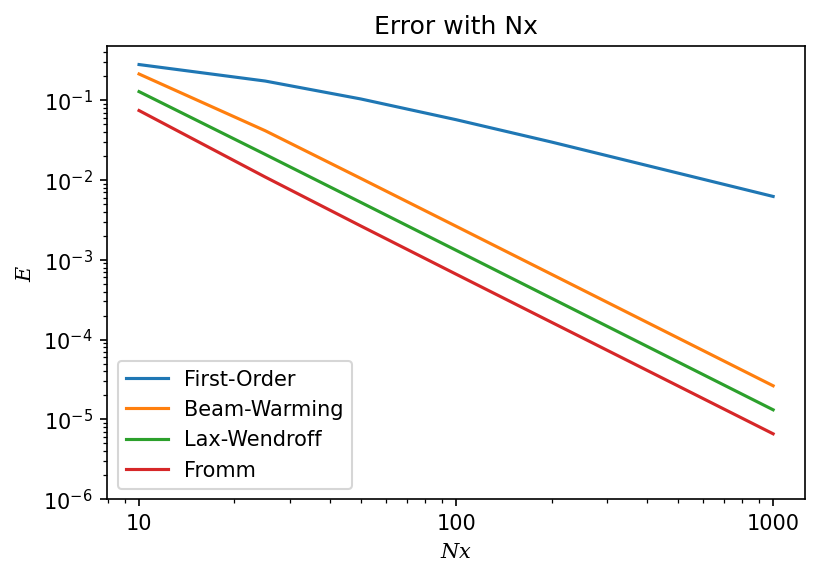

In [76]:
config.T_MAX = 2.0

fig, ax = plt.subplots()

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    errors = {}
    for num_x_cells in (10, 25, 50, 100, 200, 1000):
        config.NUM_X_CELLS = num_x_cells

        cells_a = make_regular_mesh(config)
        initialize_sine_wave(config, cells_a)

        cells_b = make_regular_mesh(config)
        initialize_sine_wave(config, cells_b)

        simulate(
            config,
            cells_b,
            simulate_step,
            periodic_boundary_conditions,
            reconstructor,
            lax_friedrichs_flux,
            time_step_integrator,
        )
        errors[config.NUM_X_CELLS] = error(config, cells_a, cells_b)
    nx_error_plot(fig, ax, errors, label=reconstructor_name)

ax.legend()
plt.show()

From the slopes of the error plot we can see that the three higher-order methods are actually second order (the slope is -2.0), giving substantially better accuracy than the first-order method. In fact, the second order methods with 100 cells give better accuracy than the first-order method with 1000 cells. Given that halving the cell size requires *four* times more computation (halving the cell size also causes halving of the time-step duration) going from 100 to 1000 is $\log_2 10$ doublings so at least a $4^{\log_2 10} = 100$ fold increase in computation time!

## Limiters

Limiters allow us to take advantage of the non-oscillatory behaviour of first-order methods in the presence of high rate of change discontinuities, and the accuracy of the second-order methods in the presence of smooth variations of the state variable. The basic idea is to limit the effect of very high spatial derivatives of the state variable.

Consider the first-order ($\text{FO}$) reconstruction method, where the reconstruction $\tilde{u}$ is equal to the cell average $\bar u$,

  $$\tilde{u}_\text{FO} = \bar u$$
  
and a second-order ($\text{SO}$) reconstruction method, where the the reconstruction $\tilde{u}$ is equal to the cell average $\bar u$ plus the gradient $\frac{\mathrm{d} u}{\mathrm{d} x}$ multiplied by the distance $x - x_0$ of the distance from the cell centroid $x_0$,

  $$\tilde{u}_\text{SO} = \bar u + \frac{\mathrm{d} u}{\mathrm{d} x}(x - x_0)$$
  
We can combine first-order and second-order methods by taking the first-order reconstruction $\tilde{u}_\text{FO}$ and adding to it the difference between the first- and second-order reconstructions $\tilde{u}_\text{SO} - \tilde{u}_\text{FO}$ multiplied by the parameter $\phi$,

  $$\tilde{u} = \tilde{u}_\text{FO} + \phi(\tilde{u}_\text{SO} - \tilde{u}_\text{FO})$$

so that setting $\phi$ to zero gives first-order reconstruction, setting phi to one given second-order reconstruction, and intermediate values given a linear blend of the two:

  $$\phi = 0 \Longrightarrow \text{first-order}$$
  
  $$\phi = 1 \Longrightarrow \text{second-order}$$
  
We can simplify $\tilde{u}$ as follows. Given,

  $$\tilde{u} = \tilde{u}_\text{FO} + \phi(\tilde{u}_\text{SO} - \tilde{u}_\text{FO})$$

substitute the expressions for $\tilde{u}_\text{SO}$ and $\tilde{u}_\text{SO}$,

  $$\tilde{u} = \bar u + \phi(\bar u + \frac{\mathrm{d} u}{\mathrm{d} x}(x - x_0) - \bar u)$$

and cancel terms to yield,

  $$\tilde{u} = \bar u + \phi(\frac{\mathrm{d} u}{\mathrm{d} x}(x - x_0))$$

The flux limiter *parameter* $\phi$ is determined by a flux limiter *function* $\phi(r)$

  $$\phi = \phi(r)$$
  
where $r$ is a measure of the smoothness of the solution, usually given by the ratio of the gradients in successive cells,

  $$r_i = \frac{u_i - u_{i-1}}{u_{i+1} - u_i}$$

When the distribution of $u$ is smooth, then the backwards difference and forwards difference will be close in value, and $r_i$ will be close to one. Around a minima or maxima of $u$, the backward difference (numerator) forward difference (denominator) will have opposite signs, so $r_i$ will be negative. For a shallowing gradient $r_i$ will be greater than one, and for a steepening gradient $r_i$ will be less than one.  In regions of zero gradient some special treatment is needed to avoid division by zero; however, the choice of treatment is not important, since where the solution is not changing choice of high- or low-order methods is irrelevant.

For the Lax-Wendroff method, $r$ is clamped to be greater than zero, giving the modified expression:

  $$r_i = \max{\left[0, \frac{u_i - u_{i-1}}{u_{i+1} - u_i}\right]}$$
  
which affects the behaviour around extrema.

In [77]:
def gradient_ratio(cells, i, rk, epsilon=1e-6):
    """The ratio of successive gradients on the solution mesh.
    
    Args:
        cells: The collections of cells.
        i: The cell index around which the successive forwards and backwards gradients will be taken.
        rk: The Runge-Kutta step.
        epsilon: A small value used to prevent division by zero.
        
    Returns:
        The ratio of successive gradients.  
    """
    backwards = (cells[i].u[rk] - cells[i - 1].u[rk])
    forwards = (cells[i + 1].u[rk] - cells[i].u[rk])
    return backwards / (forwards or epsilon)

### Total variation diminishing (TVD)

In the discrete case, *variation* is defined as the absolute difference between successive cell values, 

  $$\text{Variation} = \left|{\bar u}_i - {\bar u}_{i - 1}\right|$$
  
and the *Total Variation* ($\text{TV}$) is the sum of variation over all cells,

  $$\text{TV} = \sum_{i}^{N_x} \left|{\bar u}_i - {\bar u}_{i - 1}\right|$$
  
A numerical method is said to be [Total Variation Diminishing](https://en.wikipedia.org/wiki/Total_variation_diminishing) if total variation is the same or reduced between successive timesteps:

  $$\text{TV}(u^{n+1}) \leq \text{TV}(u^{n})$$
  

### Sweby Diagrams

A *Sweby Diagram* can be used to illustrate the behaviour of different flux limiter functions. Sweby ((Sweby, P. (1984) [High Resolution Schemes Using Flux Limiters for Hyperbolic Conservation Laws](https://epubs.siam.org/doi/abs/10.1137/0721062))) showed that 
in order for a flux limiting scheed to possess the properties of being TVD, and monotonically varying in regions where the solution should be monotone, the following inequalities must hold:

  $$0 \leq \phi(r) \leq 2r$$
  
  $$0 \leq \phi(r) \leq 2$$

We can plot this region on a $r$-$\phi$ plot:

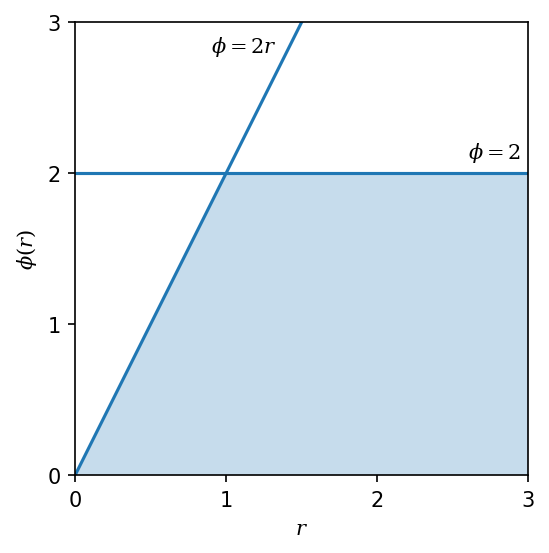

In [78]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon


def sweby_plot(ax, phi_eq_2r=False, phi_eq_r=False, phi_eq_1=False, phi_eq_2=False, first_order_tvd=False, second_order_tvd=False):
    ax.set_aspect('equal')
    ax.set_ylim(0.0, 3.0)
    ax.set_ylabel('$\phi(r)$')
    ax.set_yticks(range(0, 4))
    ax.set_xlim(0.0, 3.0)
    ax.set_xlabel('$r$')
    ax.set_xticks(range(0, 4))
    if phi_eq_2r:
        ax.axline((0.0 ,0.0), (1.0, 2.0))
        ax.text(0.9, 2.8, "$\phi = 2r$")
    if phi_eq_2:
        ax.axline((0.0, 2.0), (3.0, 2.0))
        ax.text(2.6, 2.1, "$\phi = 2$")
    if phi_eq_1:
        ax.axline((0.0, 1.0), (3.0, 1.0))
        ax.text(2.6, 1.1, "$\phi = 1$")
    if phi_eq_r:
        ax.axline((0.0, 0.0), (3.0, 3.0))
        ax.text(2.4, 2.8, "$\phi = r$")
    ax.fill(
        (0, 0), "b",
    )
    patches = []
    if first_order_tvd:
        patches.append(
            Polygon(
                [
                    (0.0, 0.0),
                    (1.0, 2.0),
                    (3.0, 2.0),
                    (3.0, 0.0),
                ],
                closed=True
            )
        )
    if second_order_tvd:
        patches.extend(
            [
                Polygon(
                    [
                        (0.0, 0.0),
                        (0.5, 1.0),
                        (1.0, 1.0),
                    ],
                    closed=True
                ),
                Polygon(
                    [
                        (1.0, 1.0),
                        (2.0, 2.0),
                        (3.0, 2.0),
                        (3.0, 1.0),
                    ],
                    closed=True
                ),
            ],
        )
    if patches:
        ax.add_collection(
            PatchCollection(
                patches,
                alpha=0.25
            )
        )

fig, ax = plt.subplots()
sweby_plot(ax, phi_eq_2r=True, phi_eq_2=True, first_order_tvd=True)
plt.show()

Different reconstruction techniques can be plotted on this diagram: The Lax-Wendroff scheme at $\phi(r) = 1$, and the Beam-Warming scheme at $\phi = r$.

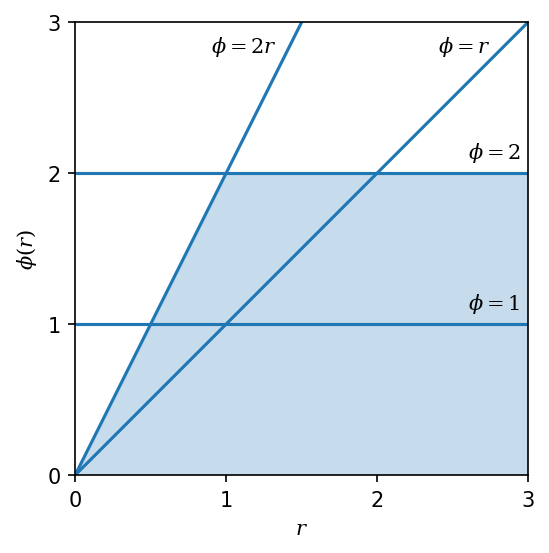

In [79]:
fig, ax = plt.subplots()

sweby_plot(ax, phi_eq_2r=True, phi_eq_2=True, phi_eq_1=True, phi_eq_r=True, first_order_tvd=True)

plt.show()

<div class="alert alert-block alert-warning">
    The details of how and why the Lax-Wendroff and Beam-Warming schemes can be plotted as these two lines are glossed over for now, until I can derive them myself. I don't quite get it yet
    
    Substituting $\phi(r) = 1$, into
    
      $$\tilde{u} = \bar u + \phi(r)(\frac{\mathrm{d} u}{\mathrm{d} x}(x - x_0))$$
    
    gives 
  
      $$\tilde{u} = \bar u + \frac{\mathrm{d} u}{\mathrm{d} x}(x - x_0)$$
    
    ...
    
</div>

Furthermore, it has been found that second-order TVD limiters should be *between* the Lax-Wendroff scheme at $\phi(r) = 1$, and the Beam-Warming scheme at $\phi = r$ to be non-oscillatory, indicated by the darker region below:

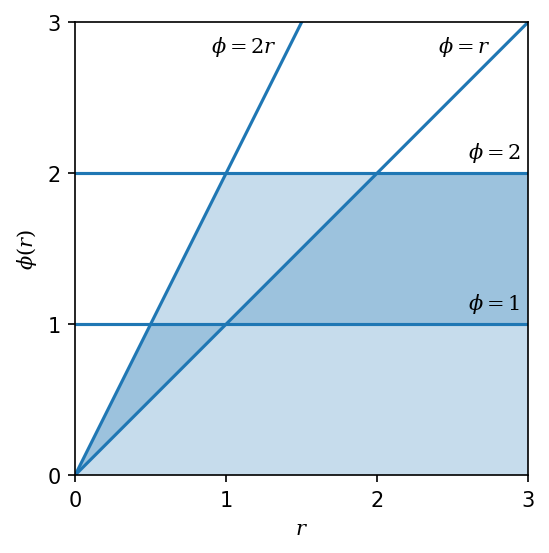

In [80]:
fig, ax = plt.subplots()

sweby_plot(ax, phi_eq_2r=True, phi_eq_2=True, phi_eq_r=True, phi_eq_1=True, first_order_tvd=True, second_order_tvd=True)

plt.show()

Notably, it can bee seen that limiter functiontion *must* pass through the points at $(r=0, \phi(r)=0)$ and $(r=1, \phi(r)=1)$. When $r = 1$, the solution $u$ is very smooth because the forwards and backwards differences are equal, so we want to use a second-order scheme, which we get when $\phi(r)=1$. Remember that $r$ is clamped to be non-negative, so negative $r$ is treated as zero, where we want first-order schemes to handle minima and maxima in the solution.

### Well-known TVD limiters

There are many limiter functions, but no single limiter function has been found to be applicable in all situations.

Some limiter functions have the property of being symmetric, showing the following property:

  $$\frac{\phi(r)}{r} = \phi\left(\frac{1}{r}\right)$$
  
which is useful as it ensure that the limiting function applies to forward and backward gradients in the same way.

#### minmod limiter

  $$\phi_\text{mm}(r) = \max\left[0, \min(1, r)\right]$$
  
  $$\lim\limits_{r \to \infty} \phi_\text{mm}(r) = 1$$

In [81]:
def minmod_limiter(r):
    return max(0, min(1, r))

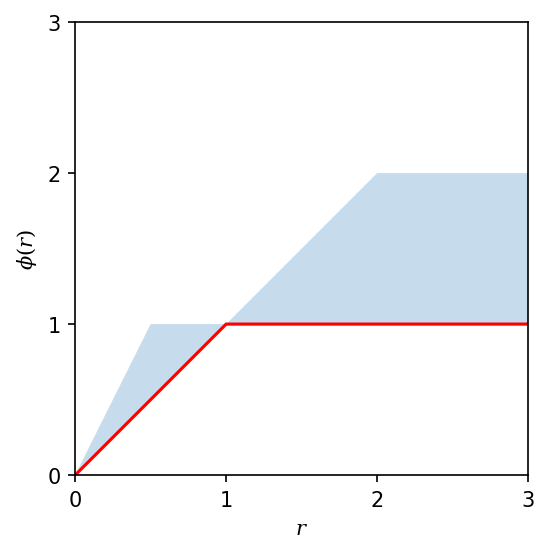

In [82]:
fig, ax = plt.subplots()

sweby_plot(ax, second_order_tvd=True)

rs = np.linspace(0, 3, 7)
ax.plot(rs, [minmod_limiter(r) for r in rs], color="red")

plt.show()

#### superbee limiter

  $$\phi_\text{sb} = \max\left[0, \min(2r, 1), \min(r, 2)\right]$$
    
  $$\lim\limits_{r \to \infty} \phi_\text{sb}(r) = 2$$

In [83]:
def superbee_limiter(r):
    return max(0, min(1, 2*r), min(r, 2))

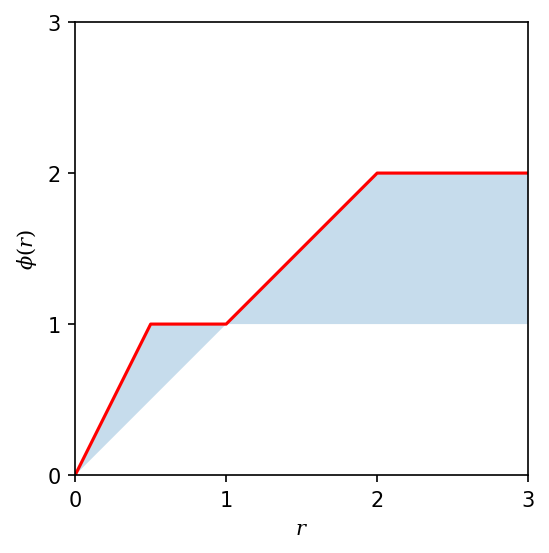

In [84]:
fig, ax = plt.subplots()

sweby_plot(ax, second_order_tvd=True)

rs = np.linspace(0, 3, 7)
ax.plot(rs, [superbee_limiter(r) for r in rs], color="red")

plt.show()

#### van Leer limiter

  $$\phi_\text{vl}(r) = \frac{r + |r|}{1 + |r|}$$
  
  $$\lim\limits_{r \to \infty} \phi_\text{vl}(r) = 2$$

In [85]:
def van_leer_limiter(r):
    return (r + abs(r))/(1 + abs(r))

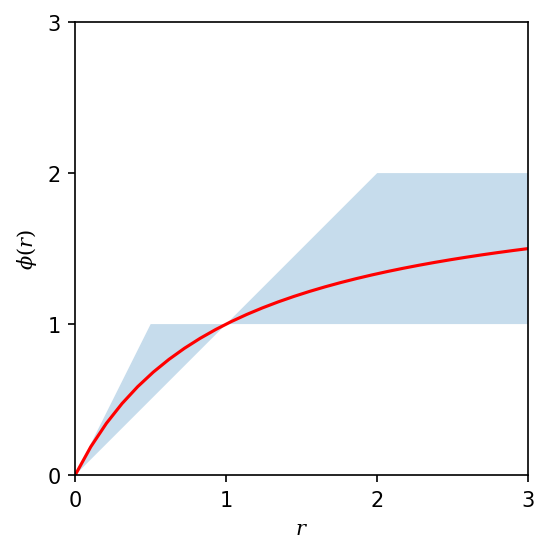

In [86]:
fig, ax = plt.subplots()

sweby_plot(ax, second_order_tvd=True)

rs = np.linspace(0, 3, 30)
ax.plot(rs, [van_leer_limiter(r) for r in rs], color="red")

plt.show()

#### van Albada limiter

symmetric (van Albada, et al., 1982)

  $$\phi_\text{val}(r) = \frac{r^2 + r}{r^2 + 1}$$
  
  $$\lim\limits_{r \to \infty} \phi_\text{val}(r) = 1$$

In [87]:
def van_albada_limiter(r):
    return (r**2 + r)/(r**2 + 1)

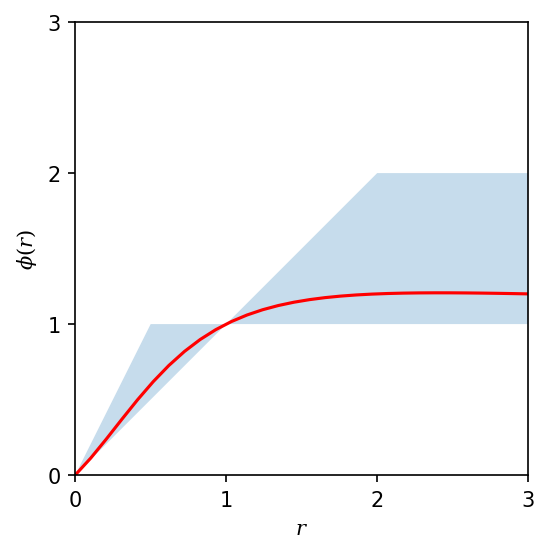

In [88]:
fig, ax = plt.subplots()

sweby_plot(ax, second_order_tvd=True)

rs = np.linspace(0, 3, 30)
ax.plot(rs, [van_albada_limiter(r) for r in rs], color="red")

plt.show()

### Flux-limited forward difference (Lax-Wendroff) reconstruction

This limiter combines the van Albada limiter with the Lax-Wendroff reconstruction we made earlier. For the Lax-Wendroff method the gradient ratio $r$ must be non-negative. We calculate $r$ by taking the maximum of zero and the successive gradients, and use this to compute $\phi$. This is then used to multiply the derivative term in the left and right reconstructions, causing the gradual switching from first- to second-order reconstuction.

In [89]:
def reconstruct_lax_wendroff_limited(config, cells, rk):
    """Lax-Wendroff reconstruction of values at cell boundaries.
    
    Using forwards differences.
    """
    for i in range(config.NUM_GHOST_CELLS - 1, config.NUM_X_CELLS + config.NUM_GHOST_CELLS + 1):
        r =  max(0, gradient_ratio(cells, i, rk))
        phi = van_albada_limiter(r)
        dx = cells[i].dx  # This routine assumes a regular grid with constant dx
        du_dx = (cells[i + 1].u[rk] - cells[i].u[rk]) / dx 
        cells[i].u_left = cells[i].u[rk] - phi * du_dx * dx/2.0
        cells[i].u_right = cells[i].u[rk] + phi * du_dx * dx/2.0

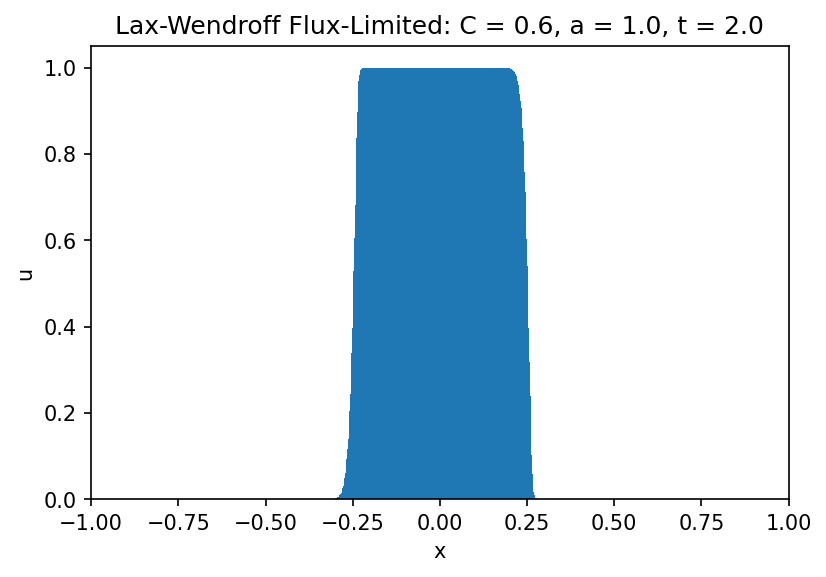

In [90]:
cells = make_regular_mesh(config)
initialize_square_wave(config, cells)
time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]
simulate(
    config,
    cells,
    simulate_step,
    periodic_boundary_conditions,
    reconstruct_lax_wendroff_limited,
    lax_friedrichs_flux,
    time_step_integrator,
)
fig, ax = plt.subplots()
cell_bar_plot(fig, ax, config, cells, title=(
        "Lax-Wendroff Flux-Limited: "
        f"C = {config.COURANT_NUMBER}, "
        f"a = {config.ADVECTION_VELOCITY}, "
        f"t = {config.T_MAX}"))
plt.show()

Registering our new limiter,

In [91]:
RECONSTRUCTORS["Flux-limited Lax-Wendroff"] = reconstruct_lax_wendroff_limited

we can compare,

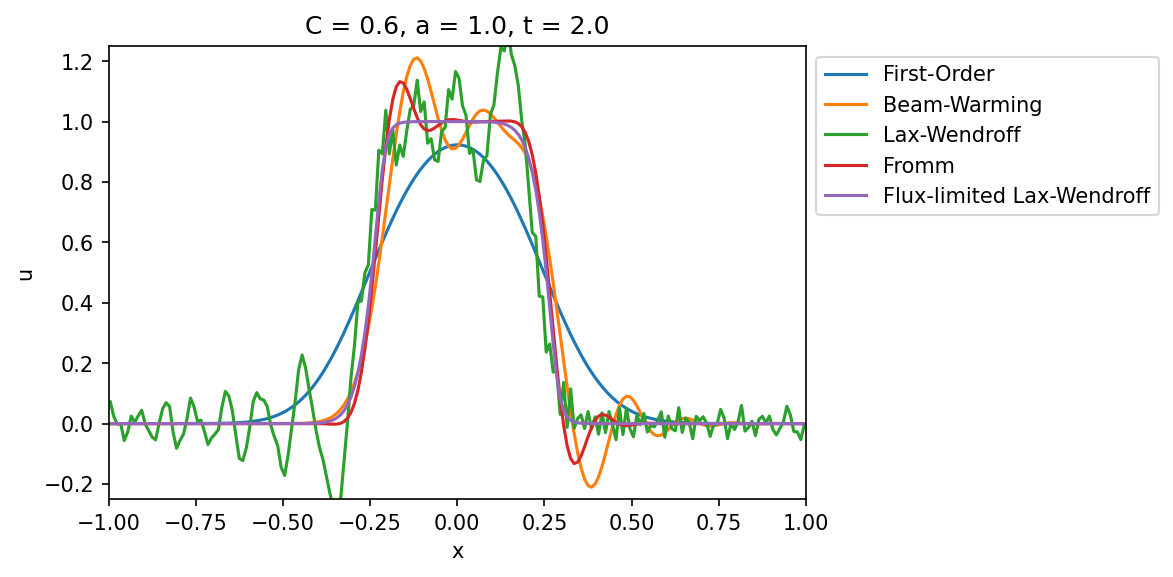

In [92]:
config = Config()
config.NUM_X_CELLS = 200
config.NUM_GHOST_CELLS = 3
config.X_MIN = -1.0
config.X_MAX = 1.0
config.T_MAX = 2.0
config.MAX_NUM_TIME_ITER = 100000
config.COURANT_NUMBER = 0.6
config.ADVECTION_VELOCITY = 1.0
config.NUM_RK_STEPS = 3

# Ensure that the advection velocity, model width conspire to move the
# wave back to it's initial position at T_MAX, so the initial conditions can be
# used as an exact solution to compare methods
assert (config.T_MAX * config.ADVECTION_VELOCITY) % (config.X_MAX - config.X_MIN) == 0.0, \
       "Advection velocity does not transport an exact number of spatial periods"

fig, ax = plt.subplots()

ax.set_title(
    f"C = {config.COURANT_NUMBER}, "
    f"a = {config.ADVECTION_VELOCITY}, "
    f"t = {config.T_MAX}"
)
ax.set_ylim(-0.25, 1.25)
ax.set_ylabel('u')
ax.set_xlim(config.X_MIN, config.X_MAX)
ax.set_xlabel('x')

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    
    cells = make_regular_mesh(config)
    initialize_square_wave(config, cells)

    simulate(
        config,
        cells,
        simulate_step,
        periodic_boundary_conditions,
        reconstructor,
        lax_friedrichs_flux,
        time_step_integrator,
    )

    ax.plot(
        [cells[i].cx for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        label=reconstructor_name
    )

ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

Let's perform an order of accuracy analysis to compare the Flux-limited Lax-Wendroff scheme to the other schemes. 

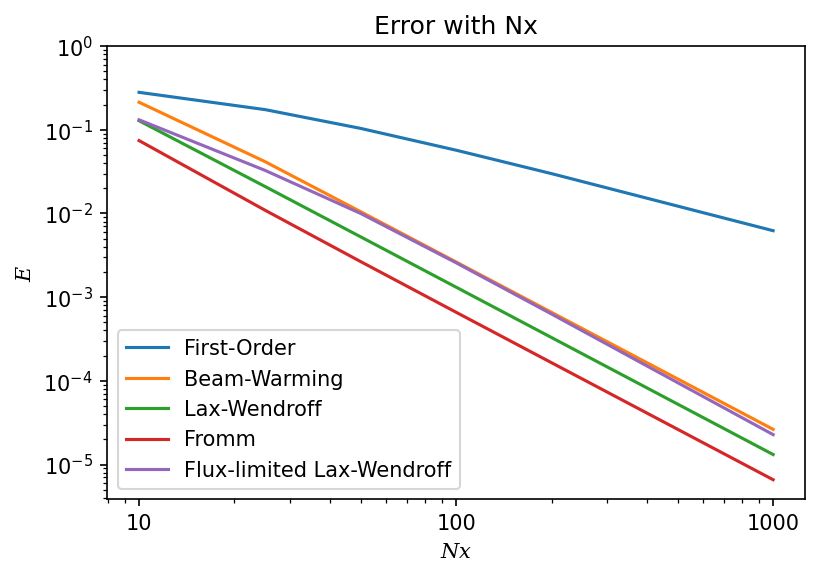

In [93]:
config.T_MAX = 2.0

fig, ax = plt.subplots()

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    errors = {}
    for num_x_cells in (10, 25, 50, 100, 200, 1000):
        config.NUM_X_CELLS = num_x_cells

        cells_a = make_regular_mesh(config)
        initialize_sine_wave(config, cells_a)

        cells_b = make_regular_mesh(config)
        initialize_sine_wave(config, cells_b)

        simulate(
            config,
            cells_b,
            simulate_step,
            periodic_boundary_conditions,
            reconstructor,
            lax_friedrichs_flux,
            time_step_integrator,
        )
        errors[config.NUM_X_CELLS] = error(config, cells_a, cells_b)
    nx_error_plot(fig, ax, errors, label=reconstructor_name)

ax.legend()
plt.show()

With a sine curve distribution of $u$ the error is very similar to that for unmodified Lax-Wendroff. This is to be expected, as the van Albada flux limiter is designed to not have much effect when the solution is smooth. To demonstrate the need for flux limiting, we can instead use the square wave situation with shocks:

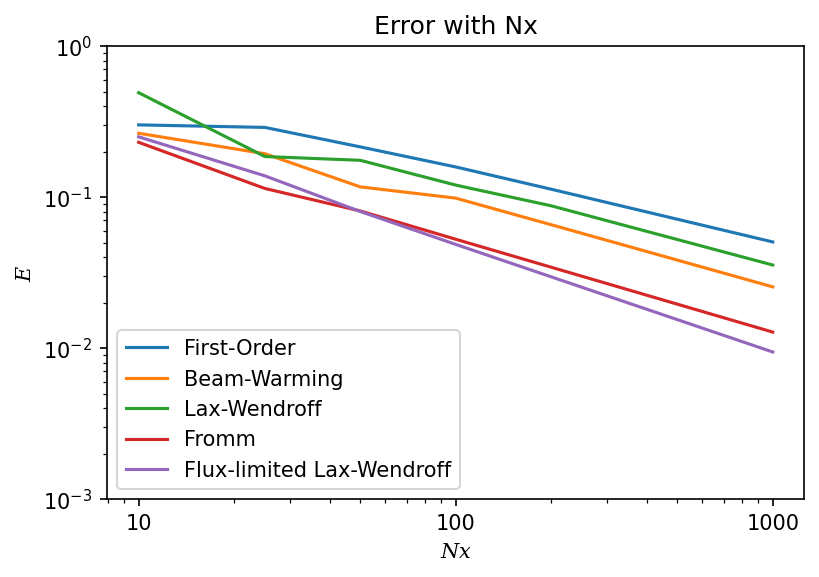

In [94]:
config.T_MAX = 2.0

fig, ax = plt.subplots()

time_step_integrator = TIME_STEP_INTEGRATORS[config.NUM_RK_STEPS]

for reconstructor_name in RECONSTRUCTORS:
    reconstructor = RECONSTRUCTORS[reconstructor_name]
    errors = {}
    for num_x_cells in (10, 25, 50, 100, 200, 1000):
        config.NUM_X_CELLS = num_x_cells

        cells_a = make_regular_mesh(config)
        initialize_square_wave(config, cells_a)

        cells_b = make_regular_mesh(config)
        initialize_square_wave(config, cells_b)

        simulate(
            config,
            cells_b,
            simulate_step,
            periodic_boundary_conditions,
            reconstructor,
            lax_friedrichs_flux,
            time_step_integrator,
        )
        errors[config.NUM_X_CELLS] = error(config, cells_a, cells_b)
    nx_error_plot(fig, ax, errors, label=reconstructor_name)

ax.legend()
plt.show()

In this case, the flux-limited model has lower error than any of the other reconstruction schemes for more that about 50 cells. In fact the flux limited scheme at ~50 cells gives similar error to the non-flux-limited scheme with about 300 cells.

## WENO (Weighted Essentially Non-Oscillatory) schemes

The [ENO](https://en.wikipedia.org/wiki/ENO_methods) and [WENO](https://en.wikipedia.org/wiki/WENO_methods) methods, with the latter being developed in the mid-1990s. They provide an alternative to flux limiters for dealing with discontinuities (shocks) in the distribution of the the state variable.  Both ENO and WENO methods work by combining multiple smaller, lower-order stencils together into a single larger, higher-order stencil. The small lower-order stencils may cover, say, three cells, and the large higher-order stencil may be over five cells. The small stencils are shifted with respect to the large stencil.  The ENO method works by choosing the stencil with the smoothest solution. The superior WENO method combines all the small stencil results, weighting them to form a higher-order solution from a [convex combination](https://en.wikipedia.org/wiki/Convex_combination) of the lower-order solutions. In what follows, we will implement the [WENO-JS (Jiang-Shu)](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.7.6297) scheme on our regular one-dimensional grid.

### Large and Small Stencils

To illustrate we will work on a very small domain of only seven cells.

In [95]:
config.NUM_X_CELLS = 7
config.NUM_GHOST_CELLS = 0
config.X_MIN = -7/2
config.X_MAX = +7/2
config.T_MAX = 2.0
config.MAX_NUM_TIME_ITER = 100000
config.COURANT_NUMBER = 0.6
config.ADVECTION_VELOCITY = 1.0
config.NUM_RK_STEPS = 3

Our grid will be regular:

In [96]:
cells = make_regular_mesh(config)

and small enough that we can initialize the state variable average in each cell manually:

In [97]:
cells[0].u[0] = 0.1
cells[1].u[0] = 0.2
cells[2].u[0] = 0.3
cells[3].u[0] = 0.4
cells[4].u[0] = 0.3
cells[5].u[0] = 0.2
cells[6].u[0] = 0.1

In [98]:
from itertools import chain
from operator import attrgetter
from fractions import Fraction

from matplotlib.collections import LineCollection

def large_scale_cell_plot(fig, ax, config, cells, title=None, y_min=None, y_max=None, x_min=None, x_max=None):
    
    ax.bar(
        [cells[i].x_left for i in real_cell_indices(config)],
        [cells[i].u[0] for i in real_cell_indices(config)],
        width=[cells[i].dx for i in real_cell_indices(config)],
        align="edge",
        color="aliceblue",
        edgecolor="lightsteelblue",
        linewidth=1,
    )
    ax.set_title(title)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('$u$')
    ax.set_xlim(
        x_min if (x_min is not None) else config.X_MIN,
        x_max if (x_max is not None) else config.X_MAX,
    )
    ax.set_xticks(
        ticks=[-3, -2, -1, 0, 1, 2, 3]
    )
    ax.set_xticklabels(
        labels=[
            "$i{sign}{mag}$".format(
                sign=("", "+", "-")[(cell.cx > 0) - (cell.cx < 0)],
                mag=int(abs(cell.cx)) or ""
            ) for cell in cells
        ]
    )
    ax.tick_params(axis="x", length=0)
    
    boundary_ticks = list(
        chain(
            map(attrgetter("x_left"), cells),
            [cells[-1].x_right]
        )
    )
    boundary_axis = ax.secondary_xaxis("bottom")
    boundary_axis.set_xticks(
        ticks=boundary_ticks
    )
    boundary_axis.set_xticklabels(
        labels=[
            r"$i{sign}\frac{{{f.numerator}}}{{{f.denominator}}}$".format(
                sign="+" if tick > 0 else "-",
                f=abs(Fraction(tick)))
            for tick in boundary_ticks
        ],
        fontsize=7,
    )
    boundary_axis.tick_params(direction="out", pad=12)
    
    return fig, ax

def stencil_span(fig, ax, cells, y, *, end_ticks=True, internal_ticks=True, tick_height, color=None, label=None):
    min_x = cells[0].x_left
    max_x = cells[-1].x_right
    segments = []
    span_segment = (
        (min_x, y),
        (max_x, y),
    )
    segments.append(span_segment)
    tick_xs = []
    if end_ticks:
        tick_xs.extend((min_x, max_x))
    if internal_ticks:
        tick_xs.extend(
            cell.x_left for cell in cells[1:]
        )
    if end_ticks or internal_ticks:
        for tick_x in tick_xs:
            tick_segment = (
                (tick_x, y - tick_height/2),
                (tick_x, y + tick_height/2),
            )
            segments.append(tick_segment)
    line_collection = LineCollection(segments, color=color, label=label)
    ax.add_collection(line_collection)
      

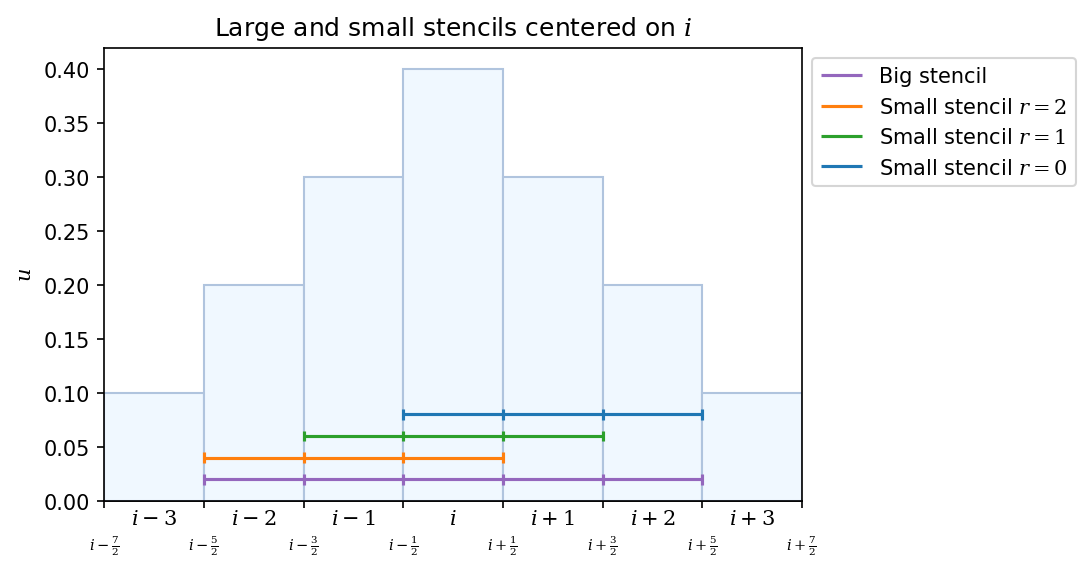

In [99]:
fig, ax = plt.subplots()
large_scale_cell_plot(fig, ax, config, cells, title=r"Large and small stencils centered on $i$")
stencil_span(fig, ax, cells[1:6], y=0.02, tick_height=0.01, color="tab:purple", label="Big stencil")
stencil_span(fig, ax, cells[1:4], y=0.04, tick_height=0.01, color="tab:orange", label="Small stencil $r=2$")
stencil_span(fig, ax, cells[2:5], y=0.06, tick_height=0.01, color="tab:green", label="Small stencil $r=1$")
stencil_span(fig, ax, cells[3:6], y=0.08, tick_height=0.01, color="tab:blue", label="Small stencil $r=0$")
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

The chart above illustrates the stencil configuration for a WENO-5 scheme centered on the cell $i$, which will have order of accuracy five. The small stencils, each covering three cells will each give an order of accuracy $k$ reconstruction, with $k = 3$. This is because the order of accuracy is equal to the number of cells spanned by the stencil. Moreover, each of the shifted small stencils must incorporate the central cell $i$, and so are $k = 3$ small stencils. Each of the small stencils is shifted left by $r$ cells from having its left-most cell in position $i$, for $0 \le r < k$. The big stencil occupies the union of all the cells spanned by the collection of small stencils, so spans $2k - 1$ cells, which in this case equals five. In order for there to be a central cell, the WENO schemes in use tend to have an odd-numbered order of accuracy. WENO-3, WENO-5 and WENO-7, and so on, but even-numbered schemes are possible.

The idea is that a weighted combination of the $k$ small stencils, together spanning $2k - 1$ cells of the big stencil, can yield an order of accuracy of $2k - 1$. The weights for each small stencil will be a adjusted based on the smoothness of the solution within each small stencil, so that discontinuities (shocks) in the solution can be accommodated without causing oscillations in the solution, by giving less-smooth small stencils relatively lower weighting. This progressively dials down the order of accuracy around shocks to achieve a simular effect to that provided by flux-limiters.

### Reconstruction polynomials

Within each small stencil the solution will be reconstructed by a polynomial from which we can determine $u$ at the cell boundaries at $i - ½$ and $i + ½$ to give left and right values $u_{i - ½}$ and $u_{i + ½}$ respectively.

To find a polynomial which fits through points we can use a [Lagrange polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial). The following code uses [SympPy](https://www.sympy.org) to find Lagrange polynomials:

In [100]:
from functools import reduce
import operator

import sympy

from sympy import symbols, expand


def product(args):
    return reduce(operator.mul, args, 1)


def lagrange_polynomial(xs, ys, x_symbol=None):
    """A Langrage polynomial function which interpolates the given points.

    Args:
        xs: The x-coordinates of the points.
        ys: The y-coordinate of the points.
        x_symbol: The returned polynomial is a function of this SymPy variable, or 'x'
            if not specified.
        
    Returns:
        A SymPy expression representing the Lagrange polynomial through the supplied points. 
    """
    x = x_symbol or symbols("x")
    xs = tuple(xs)
    return sum(y * lagrange_basis(xs, j, x) for j, y in enumerate(ys))


def lagrange_basis(xs, j, x_symbol=None):
    x = x_symbol or symbols("x")
    x_j = xs[j]
    return expand(product((x - x_m) / (x_j - x_m) for x_m in xs if x_m != x_j))


def lagrange_interpolator(ps, x_symbol=None):
    """A Lagrange polynomial which interpolates the given (x, y) points.

    Args:
        ps: An iterable series of points.
        x_symbol: The returned polynomial is a function of this SymPy variable, or 'x'
            if not specified.
        
    Returns:
        A SymPy expression representing the Lagrange polynomial through the supplied points. 
    """
    xs, ys = zip(*ps)
    return lagrange_polynomial(xs, ys, x_symbol)

Naively, we might use this to attempt a reconstruction by interpolating through the average cell values at the cell centroids. Consider the small stencil with shift $r = 1$ centered on cell $i$:


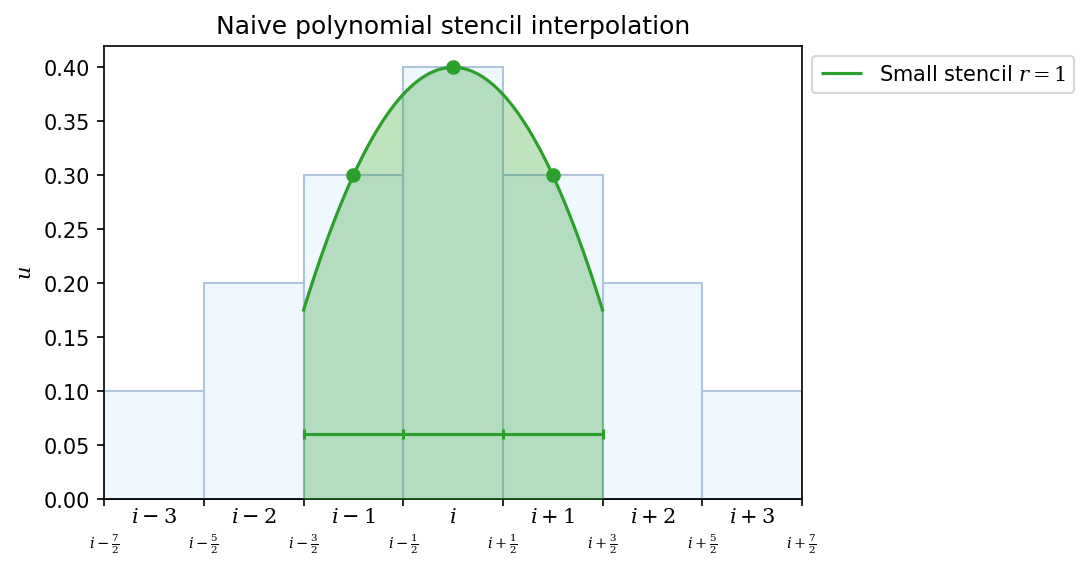

In [101]:
import numpy as np
from sympy import lambdify, symbols
    
x = symbols("x")
    
small_stencil_cells = cells[2:5]

fig, ax = plt.subplots()
large_scale_cell_plot(fig, ax, config, cells, title=r"Naive polynomial stencil interpolation")
stencil_span(fig, ax, small_stencil_cells, y=0.06, tick_height=0.01, color="tab:green", label="Small stencil $r=1$")

small_stencil_cxs = [cell.cx for cell in small_stencil_cells]
small_stencil_us = [cell.u[0] for cell in small_stencil_cells]
ax.scatter(small_stencil_cxs, small_stencil_us, color="tab:green", label=None, zorder=2)

polynomial = lambdify(symbols("x"), lagrange_polynomial(small_stencil_cxs, small_stencil_us))
poly_xs = np.linspace(-3/2, +3/2, 100)
poly_ys = [polynomial(x) for x in poly_xs]
ax.plot(poly_xs, poly_ys, color="tab:green")
ax.fill_between(poly_xs, poly_ys, color="tab:green", alpha=0.3, zorder=3)


ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

The polynomial interpolation through cell average values at centroid is clearly not conservative. The integral of the polynomial from $i - ½$ to $i + ½$ is clearly less than that given by the cell average, when in order to be a conservative reconstruction, these integrals must be equal.

What need is the unique polynomial of degree $k - 1$ whose cell average in each of the cells in the stencil is equal to $\bar u_i$. The key to finding this polynomial lies in the realisation that the continuous [primitive function](https://en.wikipedia.org/wiki/Antiderivative) (*i.e.* antiderivative) of $u(x)$ and discrete cumulative sum of cell averages progressing from left to right **must be equal at the cell boundaries**. In order words, we can know the primitive function $U(x)$ exactly at the cell boundaries.

The solution then, is to fit a $k$ degree polynomial through the *primitive* function at *cell boundries*, and then differentiate this polynomial to give a $k - 1$ degree polynomial which interpolates the value of $u$. It is this derived polynomial which can then be evaluted at the cell boundaries $i - ½$ and $i + ½$. Since the is one more cell boundary than there are cell averages in each stencil, we have the extra point needed for a degree $k$ polynomial.

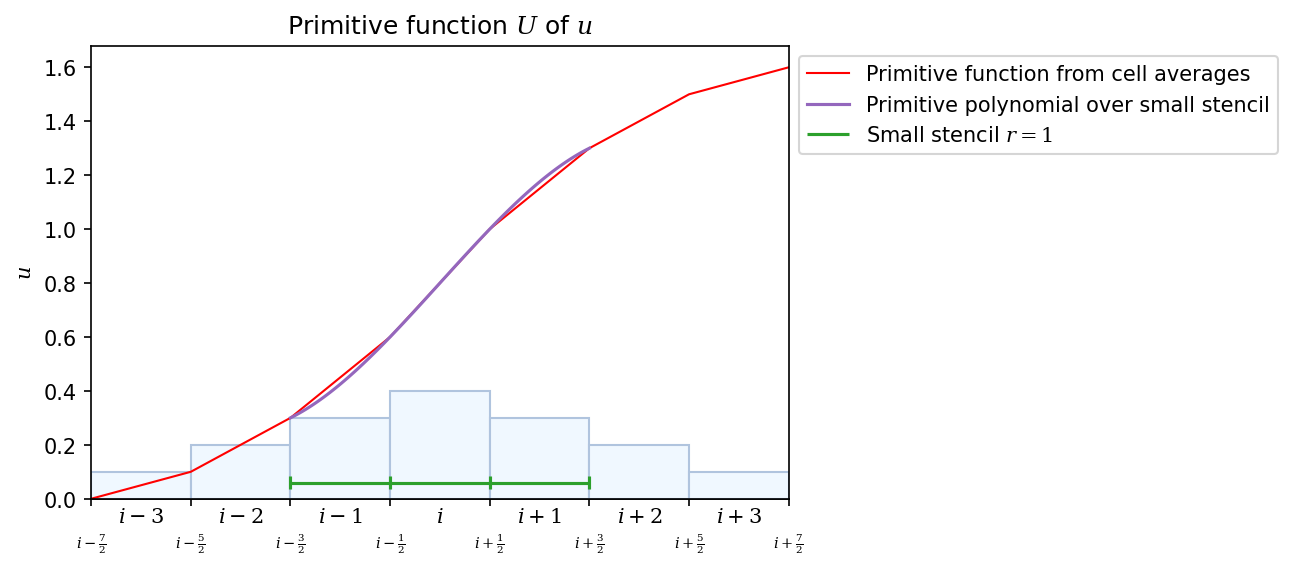

In [102]:
fig, ax = plt.subplots()
large_scale_cell_plot(fig, ax, config, cells, title=r"Primitive function $U$ of $u$")
stencil_span(fig, ax, small_stencil_cells, y=0.06, tick_height=0.05, color="tab:green", label="Small stencil $r=1$")

primitive_cells = []
primitive_u = 0
for cell in cells:
    primitive_cell = Cell(cell.cx, cell.dx, 0)
    primitive_u += cell.u[0]
    primitive_cell.u[0] = primitive_u
    primitive_cells.append(primitive_cell)
    
    
primitive_xs = [primitive_cells[0].x_left] + [primitive_cells[i].x_right for i in real_cell_indices(config)]
primitive_us = [0] + [primitive_cells[i].u[0] for i in real_cell_indices(config)]
    
ax.plot(
    primitive_xs,
    primitive_us,
    color="red",
    linewidth=1,
    label="Primitive function from cell averages"
)

small_stencil_primitive_xs = primitive_xs[2:6]
small_stencil_primitive_us = primitive_us[2:6]


primitive_polynomial = lagrange_polynomial(small_stencil_primitive_xs, small_stencil_primitive_us)
primitive_poly = lambdify(x, primitive_polynomial)
primitive_poly_xs = np.linspace(-3/2, +3/2, 100)
primitive_poly_ys = [primitive_poly(x) for x in poly_xs]
ax.plot(primitive_poly_xs, primitive_poly_ys, color="tab:purple", label="Primitive polynomial over small stencil")
#ax.fill_between(poly_xs, poly_ys, color="tab:green", alpha=0.3, zorder=3)


ax.set_ylim(0, primitive_u * 1.05)
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

The graph above shows the primitive function (**i.e.** indefinite integral) of the cell average values from negative $x$ towards postive $x$. We know that as the cell boundaries this primitive function accumulates across the discrete cell average values is equal to $\int_{-\infty}^{x} u(x)\,\mathrm{d}x$. Differentiating the polynomial interpolant of the primitive function gives a polynomial interpolant, with degree one less, of the function $u$.

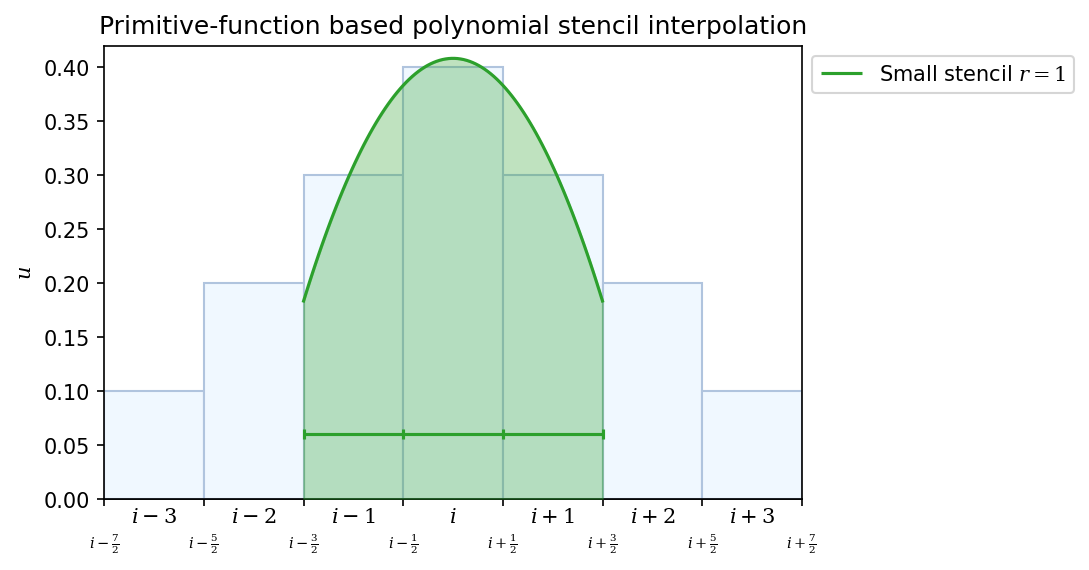

In [103]:
fig, ax = plt.subplots()
large_scale_cell_plot(fig, ax, config, cells, title=r"Primitive-function based polynomial stencil interpolation")
stencil_span(fig, ax, small_stencil_cells, y=0.06, tick_height=0.01, color="tab:green", label="Small stencil $r=1$")

poly = lambdify(x, primitive_polynomial.diff(x))
poly_xs = np.linspace(-3/2, +3/2, 100)
poly_ys = [poly(x) for x in poly_xs]
ax.plot(poly_xs, poly_ys, color="tab:green")
ax.fill_between(poly_xs, poly_ys, color="tab:green", alpha=0.3, zorder=3)

ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

To put this procedure into words and equations: For reconstructions higher than second order (linear) the average cell value $\bar u$ is not equal to the value of $u$ at the cell centroid. To work around this we consider the primitive function of $u$ which we call $U$:

  $$U(x) = \int_{-\infty}^{x} u(\xi)\,\mathrm{d}\xi$$


where $x$ is the spatial value at which we wish evaluate the primitive function (that is the point up to which we integrate), and $\xi$ is a the spatial variable on that same axis with respect to which we integrate. The lower bound of the integral is arbitrary, so long as it is less than the minimum $x$ value of the stencil.

As this integral is over cells the discretized equivalent gives an exact result at the cell boundaries,

 $$
 \begin{align}
 U(x_{i+½}) & = \sum_{j = -\infty}^{i} \int_{x_{j-½}}^{x_{j+½}} u(\xi)\,\mathrm{d}\xi\\
 & = {\Delta x} \sum_{j = -\infty}^{i} u_j
 \end{align}
 $$ 

There is a polynomial $P(x)$ which interpolates $U(x)$ at the cell boundaries. In practice we use a Lagrange Polynomial. It can be shown that the derivative of $P(x)$ denoted by $p(x)$ has definite intgrals over the cells which are equal to the cell averages:

 $$
 \begin{align}
 \int_{x_{i-½}}^{x_{i+½}} p(\xi)\,\mathrm{d}\xi & = \int_{x_{i-½}}^{x_{i+½}} P'(\xi)\,\mathrm{d}\xi\\
 & = P(x_{i+½}) - P(x_{i-½})\\
 & = U(x_{i+½}) - U(x_{i-½})\\
 & = \int_{x_{i-½}}^{x_{i+½}} u(\xi)\,\mathrm{d}\xi\\
 & = {\bar u}_i {\Delta x}
 \end{align}
 $$


By interpolating the primitive function, then differentiating this to give an interpolant of the state variable, the definite integrals over each cell properly respect the average cell value.

The function below performs the discrete integration of average cell values to give the exact values of the primitive function at cell boundaries.

In [104]:
from more_itertools import pairwise

def integrate_averages(xs, us):
    """A series of integrated values from averages.

        |   u0   |   u1   |   u2   |  ...  |   un   |
        x0      x1       x2       x3       xn      xn+1

        U0      U1       U2       U3       U4      Un+1

    Args:
        xs: A sequence x values of interval (i.e. cell) boundaries. This sequence must be
            at least one longer than us.
        us: A sequence of the average values of u within the corresponding intervals.
        
    Returns:
        A sequence of (x, U) where U is the integral of u at the cell boundaries.
    """
    num_xs = len(xs)
    num_us = len(us)
    if not num_xs >= num_us + 1:
        raise ValueError(
            f"xs with {num_xs} items does not contain at least one more item than us with {num_us} items"
        )
    s = 0
    yield xs[0], s
    for (xa, xb), u in zip(pairwise(xs), us):
        dx = xb - xa
        s += dx * u
        yield xb, s

The following function determines the polynomial $P$ which interpolates the primitive function $U$:

In [105]:
def lagrange_primitive_polynomial(xs, us, x_symbol=None):
    """The primitive function (antiderivative) of a function from averages.

        |   u0   |   u1   |   u2   |  ...  |   un   |
        x0      x1       x2       x3       xn      xn+1

        U0      U1       U2       U3       U4      Un+1

    Args:
        xs: A sequence x values of interval (i.e. cell) boundaries. This sequence must be
            at least one longer than us.
        us: A sequence of the average values of u within the corresponding intervals.
        x_symbol: The returned polynomial is a function of this SymPy variable, or 'x'
            if not specified.
            
    Returns:
        A SymPy expression representing the Lagrange polynomial through the primitive function
        of the supplied cell averages.  
    """
    primitive_points = integrate_averages(xs, us)
    return lagrange_interpolator(primitive_points, x_symbol)

### Reconstructions at cell boundaries on a regular grid

<div class="alert alert-block alert-warning">
    The constants derived in the following analytic solutions only apply for a regular grid. For an irregular grid no such constants exist.
</div>

Ultimately, we need to know the value of the state variable $u$ at the cell boundaries, and so we evaluate the reconstruction polynomial for a stencil can at the cell boundaries in which we are interested. THe mapping from the cell averages ${\bar u}_j$ in the a stencil centred on $i$ to the approximations of the cell boundary values $u_{i+½}^-$ and $u_{i-½}^+$ are linear. Therefore, there are constants $c_{rj}$ and $\tilde{c}_{rj}$ which depend on the left shift $r$ of the stencil, on the order of accuracy $k$ and on the cell size $\Delta x$, but *not* on the function $u$:

  $$u_{i+½}^- = \sum_{j = 0}^{k - 1} {c_{rj}}{\bar u}_{i - r + j},{\quad}u_{i-½}^+ = \sum_{j = 0}^{k - 1} {\tilde{c}_{rj}}{\bar u}_{i - r + j}$$


In practice we can use the `reconstruction_coefficients()` function below to compute $c_{rj}$ and $\tilde{c}_{rj}$ for a stencil. 

In [106]:
from dataclasses import dataclass
from sympy import lambdify, symbols, Add, Rational
from typing import List, Any

@dataclass
class Reconstruction:
    k: int
    r: int
    us: List[symbols]
    solution: Any
    xi: Rational
    

def reconstruction_solution(k, r, ix=1):
    """The solution at ix.
    
    Args:
        k: Order of accuracy.
        r: The right-shift of the stencil.
        ix: The position for which a reconstruction is required. Either zero
            for x_{i-½}, or one for x_{i+½}.
            
    Returns:
        The solution expression for the reconstruction at ix in terms
        of the cell average values in the stencil.
    """    
    # e.g. k = 3, gives a big stencil of 2k - 1 = 5 cells

    # |   u[j-2]  |   u[j-1]  |   u[j]  |   u[j+1]  |  u[j+2]  |
    # -2         -1           0         1           2          3

    # 0           1           2         3           4          5
    #                         i
    # i is the zero-based index of the central cell in the big stencil
    # so for k = 3, i = 2, which is k - 1
    i = k - 1

    # The stencil is composed of r cells to the left and s cells to
    # the right, symmetrically around central cell, so
    # r = s = (k - 1) // 2

    # cell boundaries over the big stencil [-2, 3] => [-2, 4)
    #
    x = symbols("x")
    dx = symbols("𝛥x")
    xs = [i * dx for i in range(-k + 1, k + 1)]
    us = [symbols("\\bar{{u}}_{{i{}}}".format(i and f"{i:+}" or "")) for i in range(-k + 1, k)]

    # The small stencil with width k can be left-shifted
    # relative to i by up to r cells where 0 <= r < k
    left = i - r
    right = i - r + k

    # We need one more cell boundary than we do cell averages
    small_stencil_xs = xs[left : right + 1]
    small_stencil_us = us[left:right]
    primitive_polynomial = lagrange_primitive_polynomial(small_stencil_xs, small_stencil_us)
    polynomial = primitive_polynomial.diff(x, 1)

    # In this cell-boundary aligned coordinate system i + 1
    # is in what we would be the i + ½ position in the cell-centered
    # coordinate system. We use a dx (cell size) of one (we assume a uniform
    # grid and the scale makes no difference to the result)
    solution = polynomial.subs(x, xs[i + ix]).subs(dx, 1).expand()
    xi = Rational(ix, 1) - Rational(1, 2)
    return Reconstruction(k, r, small_stencil_us, solution, xi)
    
def reconstruction_coefficients(reconstruction: Reconstruction):
    """The coefficients c_{rj} of the solution at ix.
    
    Args:
        reconstruction a 2-tuple of (small_stencil_us, solution, xi) as
            returned by reconstruction_solution().
            
    Returns:
        The coefficients by which to multiply the cell average values
        in the stencil to give terms which when summed give the
        reconstructed value at ix.
    """   
    coefficients = [reconstruction.solution.coeff(u) for u in reconstruction.us]
    return coefficients


In [109]:
from sympy import latex

def reconstruction_latex(reconstruction: Reconstruction, lhs=None) -> str:
    """A LaTeX string representation of the reconstruction.
    
    Args:
        reconstruction a 2-tuple of (small_stencil_us, solution, xi) as
            returned by reconstruction_solution().
            
    Returns:
        A LaTeX string reconstruction of the solution equation, with the
        terms in order and the coefficients clearly distinguished from
        the cell averages.
    """
    k = reconstruction.k
    r = reconstruction.r
    us = reconstruction.us
    xi = reconstruction.xi
    solution = reconstruction.solution
    coefficients = [solution.coeff(u) for u in us]
    if xi.p == 0:
        sub = "i"
    else:
        sign = "+-"[xi.p < 0]
        sub = f"{{i {sign} \\frac{{{abs(xi.p)}}}{{{xi.q}}}}}"
    sup = "-+"[xi.p < 0]
    if lhs is None:
        lhs = f"u_{sub}^{sup}"
    else:
        lhs = lhs.format(sub=sub, sup=sup, k=k, r=r)
    terms = [
        ("+-"[int(c.p) < 0], f"\\frac{{{abs(c.p)}}}{{{c.q}}}", latex(u))
        for c, u in zip(coefficients, us)]
    parts = [part
             for term in terms
             for part in term
            ]
    start = int(parts[0] == "+")
    rhs = " ".join(parts[start:])
    return f"{lhs} = {rhs}"

For example, for a small stencil spanning three cells, with order of accurary $k = 3$, and a right-shift $r = 1$ centering the stencil on cell $i$, the coefficients for the reconstruction at cell boundary $x_{i+½}$ (i.e. `ix = 1`) are given by:

In [110]:
from IPython.display import display, Math
reconstruction_r0 = reconstruction_solution(k=3, r=0, ix=1)
display(Math(reconstruction_latex(reconstruction_r0)))

<IPython.core.display.Math object>

From which we can extract the coefficients of the cell average terms in the stencil with,

In [111]:
reconstruction_coefficients(reconstruction_r0)

[1/3, 5/6, -1/6]

For the three small $k = 3$ stencils at $r = 0$, $r = 1$ and $r = 2$ we have the following three solutions to three polynomials:

In [112]:
display(Math(reconstruction_latex(reconstruction_solution(k=3, r=0, ix=1), r"u_{sub}^{{({r})}}")))
display(Math(reconstruction_latex(reconstruction_solution(k=3, r=1, ix=1), r"u_{sub}^{{({r})}}")))
display(Math(reconstruction_latex(reconstruction_solution(k=3, r=2, ix=1), r"u_{sub}^{{({r})}}")))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A polynomial for the big stencil with $k = 5$ can also be evaluated at $x_{i + ½}$ to give:

In [113]:
display(Math(reconstruction_latex(reconstruction_solution(k=5, r=2, ix=1), "Q(x_{sub})")))

<IPython.core.display.Math object>

This higher order polynomial is a weighted average (a [convex combination](https://en.wikipedia.org/wiki/Convex_combination)) of the three lower order polynomials:

  $$u_{i+½} = \sum_{r = 0}^{k - 1} d_r u_{i+½}^{(r)}$$
  
The coefficients $d_r$ are known in the literature as the *linear weights*. They can be determined by solving a system of equations.

In [114]:
def linear_weights(k):
    """Compute the ideal linear weights which combine small stencils to the large stencil.

    The weights give a convex combination of small stencils which is equivalent to the large
    stencil.
    """
    # The coefficients of each shifted small stencil
    small_stencils_coefficients = [reconstruction_coefficients(reconstruction_solution(k, r)) for r in range(k)]

    large_stencil_coefficients = reconstruction_coefficients(reconstruction_solution(2 * k - 1, k - 1))

    # A weight d_r is associated with each small stencil that is shifted by r places left
    weights = [symbols(f"d_{r}") for r in range(k)]

    # There are k small stencils, and hence k unknown ideal weights, so we need a system
    # of at least k equations. We have (2*k - 1) available equations, so the system is
    # overdetermined. Each equation gives the one of the large stencil coefficients
    # (i.e. for one cell boundary) as the sum of the products of each small stencil linear weights
    # with the corresponding small stencil coefficient for the same cell boundary.

    # j is the index into the cells of the large stencil
    # r is the right shift of the small stencil, and is used to locate a small stencil weights
    # (weights[r]) or the small stencil coefficients (small_stencil_coefficients[r]).
    equations = [
        sum(
            weights[r] * small_stencils_coefficients[r][r - (k - 1) + j]
            for r in range(max(0, (k - 1) - j), min(k - 1, 2 * (k - 1) - j) + 1)
        )
        - large_stencil_coefficients[j]
        for j in range(2 * k - 1)
    ]

    # This system of equations is overdetermined, so slice off the first k equations (though all
    # equations can be used when working with exact number types such as Rational). Consider using
    # a least-squares solver for inexact types.
    solution = sympy.solve(equations[:k], weights)
    return solution

In [115]:
linear_weights(k=3)

{d_0: 3/10, d_1: 3/5, d_2: 1/10}

We can see that $d_r$ is always positive and that the weights sum to one:

In [116]:
sum(linear_weights(k=3).values())

1

When the function *u* within each small stencil is smooth, we would like to the weights we use for each small stencil $\omega_r$ to be equal to the corresponding linear weight $d_r$,

  $$\omega_r = d_r$$
  
However, when a stencil spans a discontinuity in $u$, we want the corresponding weight or weights $\omega_r$ to be as close to zero as possible in order to
disregard the contribution from that small stencil. Furthermore, the weights $\omega_r$ should be smooth functions of the cell averages.

These considerations led Jiang and Shu to propose,

  $$\omega_r = \frac{\alpha_r}{\sum_{s = 0}^{k - 1} \alpha_s},\quad r = 0, \ldots, k - 1$$
  
where,

  $$\alpha_r = \frac{d_r}{(\epsilon + \beta_r)^2}$$
  
The value $\epsilon > 0$ is introduced to avoid the denominator becoming zero. Jiang and Shu propose $\epsilon = 10^{-6}$. These values $\beta_r$ are called the *smoothness* indicators of the stencil. 

In [ ]:
smoothness